In [3]:
#load rpy2 magic
%load_ext rpy2.ipython

# to switch off warning messages
import warnings
warnings.filterwarnings("ignore")

# make default cell width 85% of available screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# show multiple tables in python shells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# load R libraries & functions
%R options(warn=-1)
%R library(RColorBrewer)
%R library(ggplot2)
%R library(gplots)
%R library(gridExtra)
%R library(ggrepel)
    
# load python modules
import glob
import re
import sys
import os
import rpy2.robjects as robjects
import CGAT.Database as DB
import sqlite3
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

db = "./csvdb"

# **MEME-ChIP Report**
***
## **DREME** 
- Searches for **short**, ungapped motifs, relatively enriched vs background (flanking regions)
- TOMTOM compares discovered motifs against database(s) of known motifs

In [4]:
%%R

# R functions
theme_notebook <- function(base_size=18, base_family="helvetica") {
                  (theme_set(theme_minimal(base_size=18))
                  + theme(plot.title = element_text(face="bold", size=20, hjust=0.5),
                             text = element_text(),
                             axis.title = element_text(face="bold",size = rel(1)),
                             axis.title.y = element_text(angle=90,vjust=2, size=20),
                             axis.title.x = element_text(vjust=-0.2, size=20),
                             axis.text = element_text(size=20),
                             axis.line = element_line(colour="black"),
                             axis.ticks = element_line(),
                             legend.key = element_rect(colour = NA),
                             legend.key.size= unit(0.5, "cm"),
                             legend.margin = unit(0.5, "cm"),
                             legend.text = element_text(size=14),
                             legend.title = element_text(size=16),
                             strip.text = element_text(size=18)
                             ))
}

# Set ggplot theme
theme_set(theme_notebook(base_size=18))
Palette <- c("#E69F00", "#0072B2", "#D55E00", "#009E73", "#56B4E9",  "#999999", "#F0E442")

In [5]:
def motif_lookup(db):
    
    with open("./pipeline.ini", "r") as o:
        for line in o:
            a = re.findall("^motif_db=.*", line)
            if len(a) > 0:
                dbs = a[0].split(",")

    df1 = {}
    df2 = {}
    df3 = {}
    
    transfac = [x for x in dbs if "transfac" in x]
    jaspar = [x for x in dbs if "JASPAR" in x]
    uniprobe = [x for x in dbs if "uniprobe" in x]
    hocomoco = [x for x in dbs if "HOCOMOCO" in x]
    chen = [x for x in dbs if "chen" in x]

    n = 0
    for i in [transfac, jaspar, uniprobe]:
        n = n + 1
        if n == 1:
            db_name = "transfac"
        if n == 2:
            db_name = "jaspar"
        if n == 3:
            db_name = "uniprobe"
        meme = ''.join(i).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[2]
                    df1[motif_name] = motif_id

        if n == 1:
            dfs = pd.DataFrame.from_dict(df1, orient="index")
            dfs.columns = ["motif_id"]
            dfs["motif_name"] = dfs.index.values
            dfs.reset_index(inplace=True, drop=True)
            dfs["database"] = db_name
        else:
            dfs1 = pd.DataFrame.from_dict(df1, orient="index")
            dfs1.columns = ["motif_id"]
            dfs1["motif_name"] = dfs1.index.values
            dfs1.reset_index(inplace=True, drop=True)
            dfs1["database"] = db_name
            
            dfs = dfs.append(dfs1)

    if len(hocomoco) > 0:
        meme = ''.join(hocomoco).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(".")
                    motif[0].split(".")
                    motif_name = str(motif[0]).replace("MOTIF ", "")
                    motif_suffix = '.'.join(motif[1:3])
                    motif_id = '.'.join([motif_name, motif_suffix])
                    df2[motif_name] = motif_id

        df2 = pd.DataFrame.from_dict(df2, orient="index")
        df2.columns = ["motif_id"]
        df2["motif_name"] = df2.index.values
        df2.reset_index(inplace=True, drop=True)
        df2["database"] = "hocomoco"
    
    if len(chen) > 0:
        meme = ''.join(chen).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[1]
                    df3[motif_name] = motif_id
                
        df3 = pd.DataFrame.from_dict(df3, orient="index")
        df3.columns = ["motif_id"]
        df3["motif_name"] = df3.index.values
        df3.reset_index(inplace=True, drop=True)
        df3["database"] = "chen"
    
    # merge all dfs
    df = dfs.append([df2, df3])
    
    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("motif_table", connect, if_exists="replace", index=False)

    return df

df = motif_lookup(db)

In [6]:
def dreme_summary(db, conditions="", widths="", no_peaks="", samples=""):

    beds = glob.glob("data.dir/*_meme.bed")

    names = []
    for bed in beds:
        name = os.path.basename(bed).split("_")[0]
        names.append(name)

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")
                    
    if len(conditions)==0: # allow just one condition
        conditions = [None]

    df = []
    n = 0
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    # get corresponding meme e_values for discovered motifs from meme.txt
                    if c != None:
                        table = '_'.join([name, c, str(peaks), str(width)]) + "_Dreme_tomtom"
                        meme_out = "meme.chip.dir/" + '_'.join([name, c]) + "." + '.'.join([str(peaks), str(width)]) + "/dreme_out/dreme.txt"
                    else:
                        table = '_'.join([name, str(peaks), str(width)]) + "_Dreme_tomtom"
                        meme_out = "meme.chip.dir/" + name + "." + '.'.join([str(peaks), str(width)]) + "/dreme_out/dreme.txt"
                
                    if os.path.exists(meme_out):
                        with open(meme_out, "r") as open_meme:
                            l = 0
                            for line in open_meme:
                                motif = re.findall("^#.*", line)
                                if len(motif) > 0:
                                    l = l + 1
                                    if l > 6:
                                        motif =  [ x for x in motif if "Stopping" not in x]
                                        motif =  [ x for x in motif if "Running" not in x]
                                        motif =  [ x for x in motif if "Word" not in x]
                                        if len(motif) > 0:
                                            motif = [x for x in ''.join(motif).split() if x not in ["BEST", "#"]]
                                            motif.append(table.replace("_Dreme_tomtom", ""))
                                            df.append(motif)

    df = pd.DataFrame(df, columns = ["motif", "motif_rc", "pos", "neg", "p_value", "dreme_evalue", "run"])
    df.drop("p_value", inplace=True, axis=1)
#     df = df.drop_duplicates()

    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("dreme_motifs", connect, if_exists="replace", index=False)

    return df

dreme = dreme_summary(db)

In [8]:
def dremechip_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples
        
    if len(conditions)==0: # allow just one condition
        conditions = [None]

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

    # get existing tables in db
    dbhandle = sqlite3.connect(db)
    cc = dbhandle.cursor()
    cc.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabs = cc.fetchall()
    tables = pd.DataFrame(tabs, columns=["tables"])

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    if c != None:
                        table = '_'.join([name, c, str(peaks), str(width)]) + "_Dreme_tomtom"
                    else:
                        table = '_'.join([name, str(peaks), str(width)]) + "_Dreme_tomtom"
                   
                    if tables["tables"].str.contains(table).any():

                        statement = '''select a.query_id, a.query_consensus, a.target_id, 
                                    b.motif_name, b.database, a.e_value as tomtom_evalue, a.orientation
                                    from %(table)s a, motif_table b where a.target_id = b.motif_id 
                                    order by e_value asc''' % locals()

                        df = DB.fetch_DataFrame(statement, db)
                        df = df.drop_duplicates()
                        df["run"] = str(table).rstrip("_Dreme_tomtom")
                        df["DESeq2_comparison"] = df["run"].apply(lambda x: x.split("_")[0])
                        if c != None: 
                            df["condition"] = df["run"].apply(lambda x: x.split("_")[1])
                            df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[2])
                            df["window"] = df["run"].apply(lambda x: x.split("_")[3])
                        else:
                            df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[1])
                            df["window"] = df["run"].apply(lambda x: x.split("_")[2])


                        dfs.append(df)


    c = 0
    for df in dfs:
        c = c + 1
        if c == 1:
            motifs = df
        else:
            motifs = motifs.append(df)
        motifs.head()
            
    motifs["motif_name"] = motifs["motif_name"].apply(lambda x: x.replace("_MOUSE", ""))
    
    return motifs

motifs = dremechip_summary(db)

In [9]:
def analyse_dreme(motifs, dreme):

    # reformat dfs for merge
    motifs.rename(columns={"query_id":"motif"}, inplace=True)

    # merge dfs
    dreme_chip = pd.merge(dreme, motifs, how="inner", on=["run", "motif"])
    dreme_chip.drop_duplicates(inplace=True)

    dreme_chip["dreme_evalue"] = dreme_chip["dreme_evalue"].apply(lambda x: float(x)) # correct type
    dreme_chip["settings"] = dreme_chip["no_peaks"] + "_" + dreme_chip["window"] # make column for plot annotations

    # subset on sig motifs & sig matches
    dreme_chip = dreme_chip[(dreme_chip.tomtom_evalue < 0.05) & (dreme_chip.dreme_evalue < 0.05)].sort_values(["dreme_evalue", "tomtom_evalue"], ascending=True)
    dreme_chip = dreme_chip[dreme_chip["dreme_evalue"] != 0]
    dreme_chip = dreme_chip[dreme_chip["tomtom_evalue"] != 0]
    
    return dreme_chip

dreme_chip = analyse_dreme(motifs, dreme)

## Effect of MEME-ChIP Settings on DREME & TOMTOM

In [10]:
# make new df for plots
dreme_evalue = dreme_chip.copy(deep=True)
dreme_evalue.index.name = None
dreme_evalue.reset_index(inplace=True, drop=True)
dreme_evalue = dreme_evalue.drop_duplicates(["target_id", "motif_name", "run", "motif"], keep="first")

In [11]:
%%R -i dreme_evalue

a <- ggplot(dreme_evalue, aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue), shape=factor(query_id), alpha=condition, colour=database)) +
        geom_jitter(size=3) + 
        scale_alpha_discrete(range=c(0.4, 1)) +
        facet_grid(settings ~ DESeq2_comparison) +
        theme(legend.position="bottom", legend.direction="horizontal")
        
b <- ggplot(dreme_evalue, aes(y=-log10(dreme_evalue), x=window, fill=no_peaks)) + 
        geom_boxplot(aes(alpha=dreme_evalue), position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Dreme motif discovery", x="Peak width")
        
c <- ggplot(dreme_evalue, aes(y=-log10(tomtom_evalue), x=window, fill=no_peaks)) + 
        geom_boxplot(aes(alpha=dreme_evalue), position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Tomtom motif comparison", x="Peak width")

In [12]:
dreme_motif_no = dreme_evalue.groupby(["run", "window", "no_peaks"]).agg({"motif_name":"count"})
dreme_motif_no.reset_index(inplace=True)

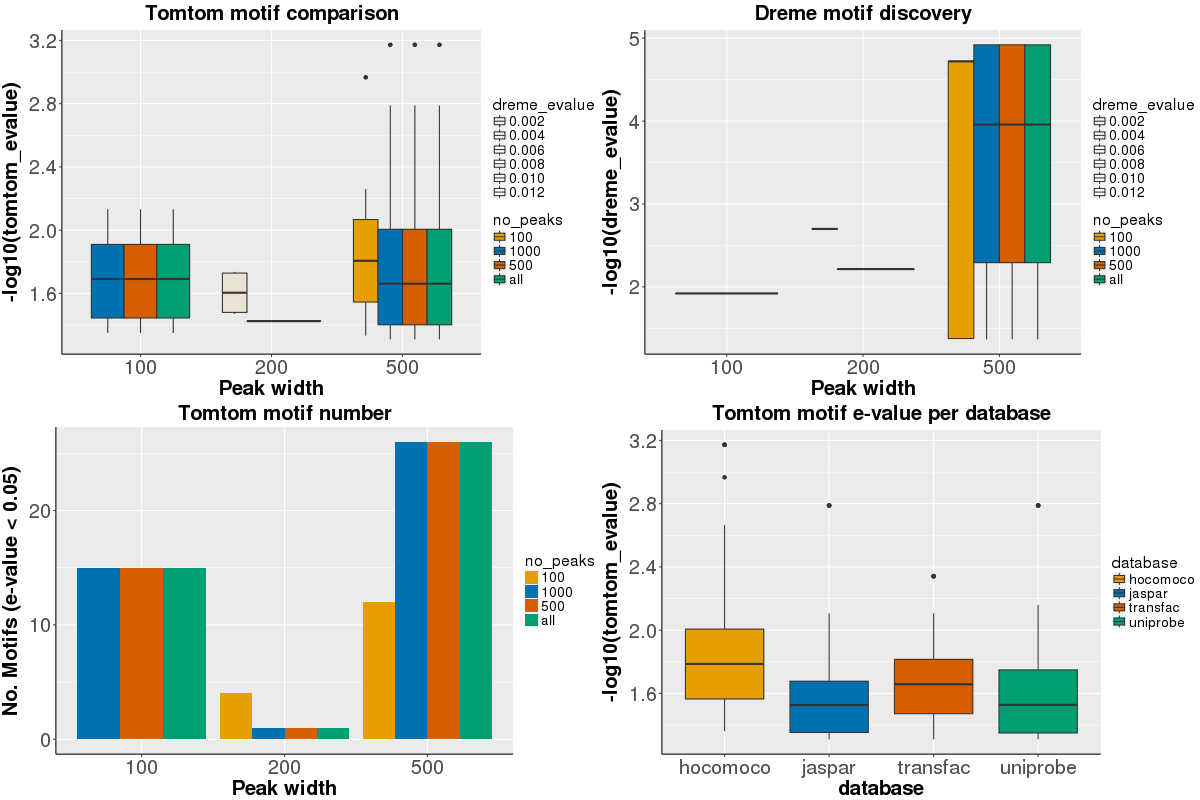

In [13]:
%%R -i dreme_motif_no,dreme_chip -w 1200 -h 800

# meme_motif_no <- meme_motif_no[order(meme_motif_no$motif_name, descending=TRUE), ]
d <- ggplot(dreme_motif_no, aes(y=motif_name, x=window, fill=no_peaks)) + 
        geom_bar(stat="identity", position="dodge")  +
        scale_fill_manual(values=Palette) + 
        labs(title="Tomtom motif number", x="Peak width", y="No. Motifs (e-value < 0.05)")# +
#         scale_x_discrete(limits=unique(meme_motif_no$window))
        
e <- ggplot(dreme_chip, aes(y=-log10(tomtom_evalue), x=database, fill=database)) + 
        geom_boxplot() +
        scale_fill_manual(values=Palette) +
        labs(title="Tomtom motif e-value per database")
        
grid.arrange(c, b, d, e, ncol=2, nrow=2)

## DREME-ChIP Summary
* For simplicity results from all MEME-ChIP runs are aggregated
    * TOMTOM & DREME e-values are averaged across runs
    * No. motif occurances between runs and databases is counted
    * All DREME motifs have an e-value < 0.05
* This is to provide an overview of the data, do not use for downstream analysis

In [15]:
# aggregate data
dreme_summary = dreme_chip.groupby(["target_id", "motif_name", "motif", "DESeq2_comparison"]).agg({"tomtom_evalue":"mean", "dreme_evalue":"mean", "run":"count", "database":"count"})
dreme_summary.reset_index(inplace=True)

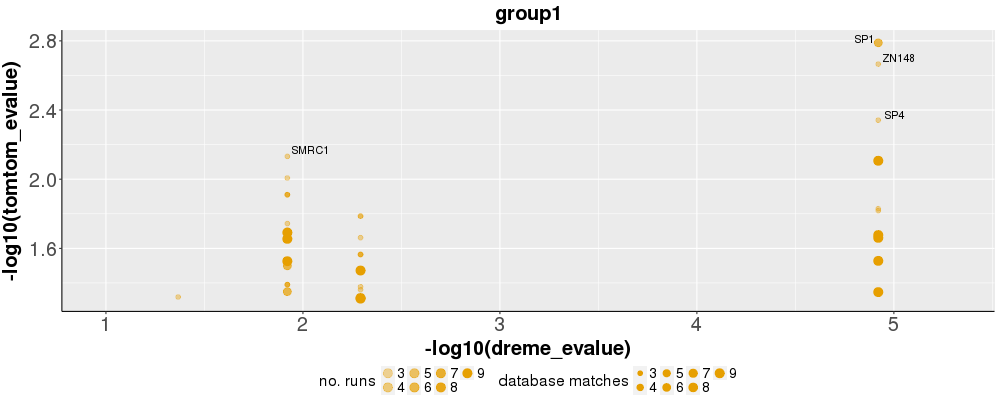

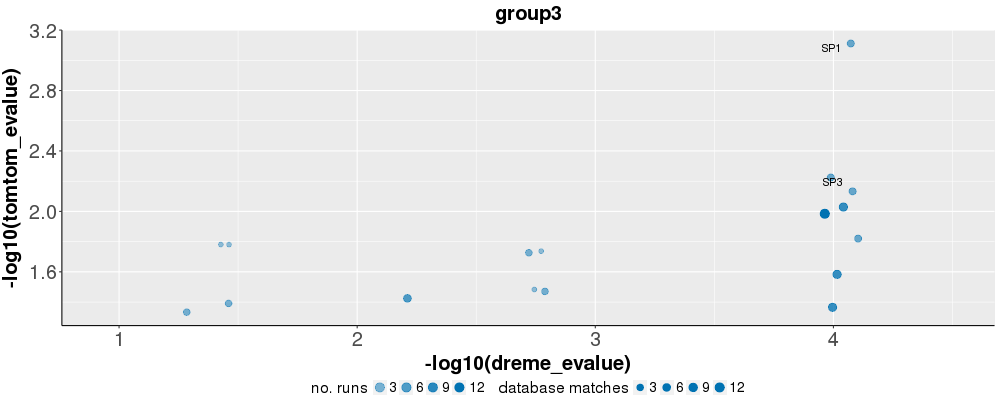

In [20]:
%%R -i dreme_summary -w 1000 -h 400

n = 0 
for (comp in unique(dreme_summary$DESeq2_comparison)){
    n = n + 1
    df <- subset(dreme_summary, DESeq2_comparison == comp)

    p <- ggplot(df, aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue), alpha=run)) +
            geom_point(aes(size=database), position=position_jitterdodge(), colour=Palette[[n]]) + 
            scale_size(range=c(2,4), name="database matches") +
            scale_alpha(range=c(0.4,1), name="no. runs") +
            scale_shape_manual(values=c(16, 17, 15), name="meme motif") +
            geom_text_repel(
                data=df[-log10(df$tomtom_evalue) > 
                          quantile(-log10(df$tomtom_evalue), 0.9, na.rm=T), ], 
                aes(label=motif_name), colour="black", alpha=1, position=position_jitterdodge()) +
#             facet_wrap(~ condition) +
            theme(legend.position="bottom", legend.direction="horizontal") +
#             scale_colour_manual(values=Palette) +
            guides(color=guide_legend(override.aes=list(size=4)), alpha=guide_legend(override.aes=list(size=4))) +
            labs(title=comp)
    
    grid.arrange(p, ncol=1, nrow=1)
}

## DREME & TOMTOM Results for Each Run & Sample
* Mutliple database hits for the same motif discovered by DREME are merged (TOMTOM e-values are averaged)

In [23]:
# make new df for plot
dreme_graph = dreme_chip.copy(deep=True)

# count occurnaces of the same motif matching a TF in many databases
# average tomtom_evalue in these instances
dreme_graph = dreme_graph.groupby(["target_id", "motif_name", "motif","orientation", "run", "DESeq2_comparison", "settings"]).agg({"database":"count", "dreme_evalue":"min", "tomtom_evalue":"mean"})
dreme_graph.reset_index(inplace=True)

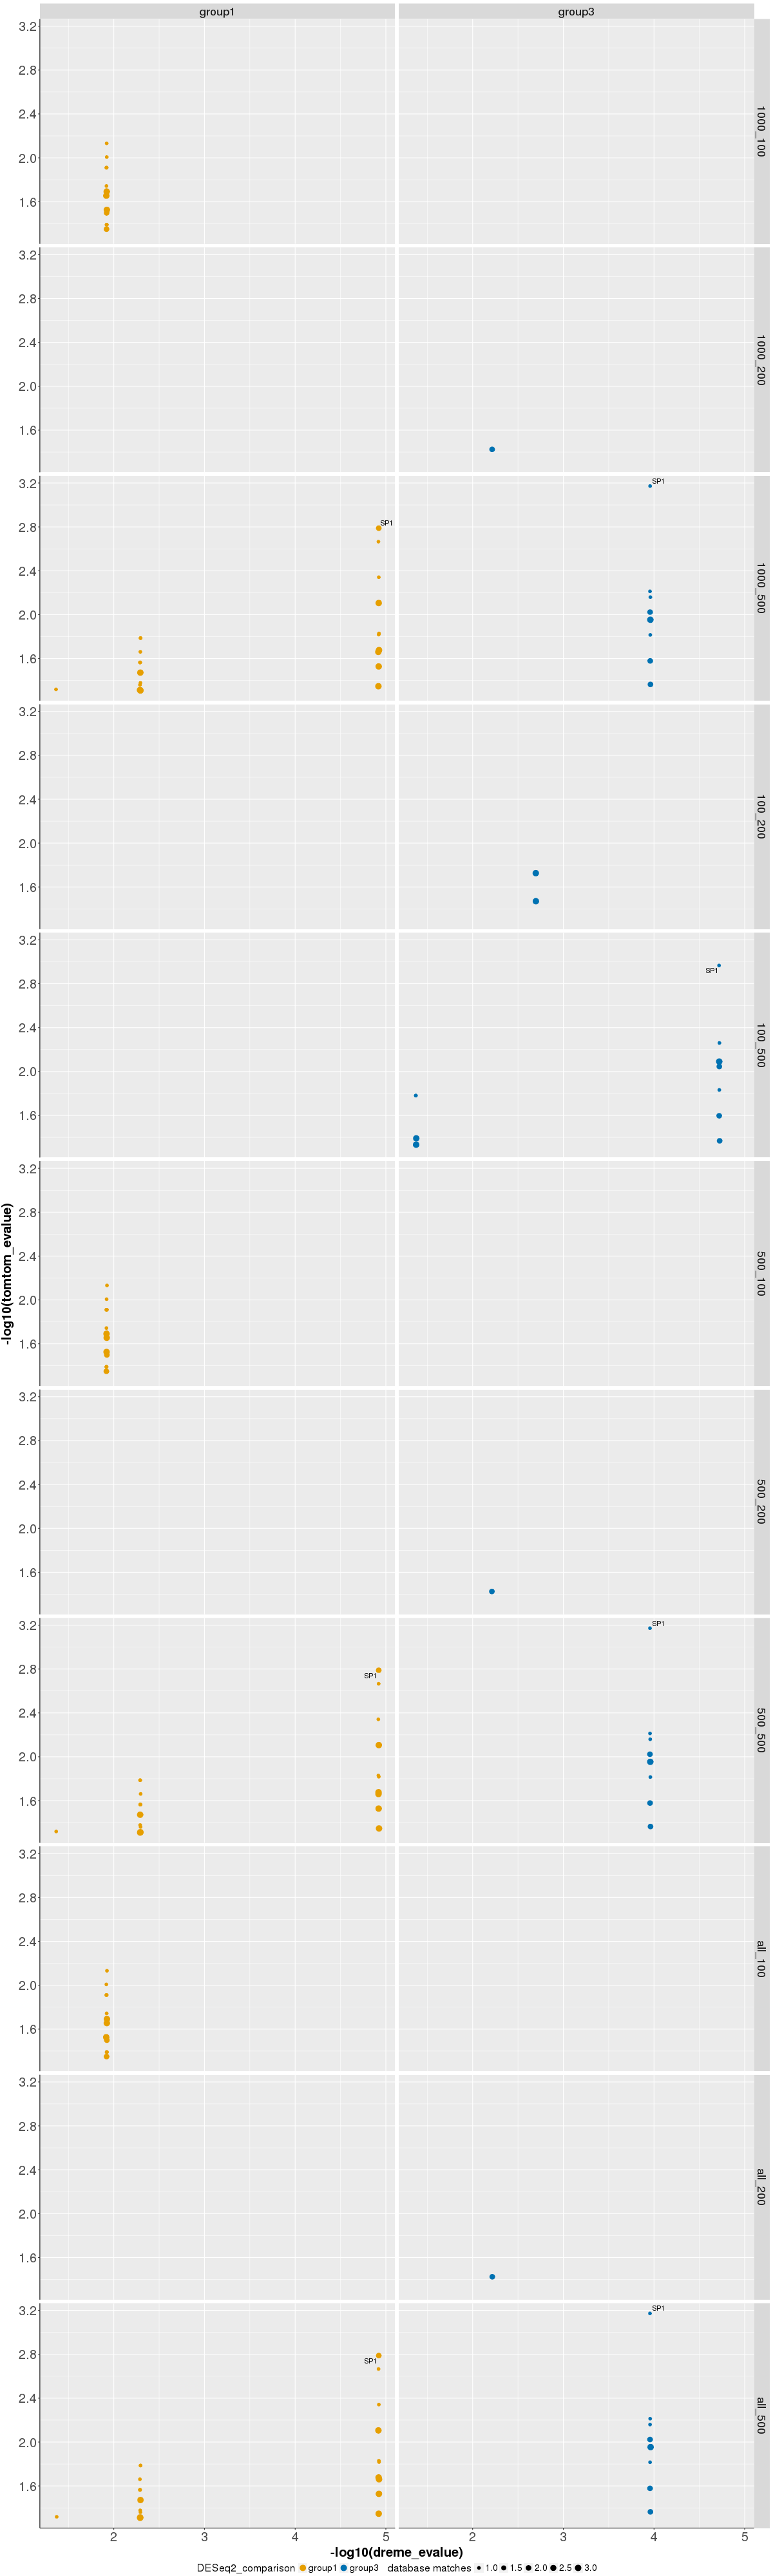

In [24]:
%%R -i dreme_graph -w 1200 -h 4000

ggplot(dreme_graph, aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue), colour=DESeq2_comparison)) +
    geom_jitter(aes(size=database)) + 
    scale_size(range=c(2,4), name="database matches") +
    geom_text_repel(data=dreme_graph[-log10(dreme_graph$"dreme_evalue") > 
                                   quantile(-log10(dreme_graph$"dreme_evalue"), 0.8, na.rm=T) &
                                   -log10(dreme_graph$"tomtom_evalue") > 
                                   quantile(-log10(dreme_graph$"tomtom_evalue"), 0.8, na.rm=T) |#, ], 
                                   -log10(dreme_graph$"dreme_evalue") > quantile(-log10(dreme_graph$"dreme_evalue"), 0.95, na.rm=T)  &
                                   -log10(dreme_graph$"tomtom_evalue") > 
                                   quantile(-log10(dreme_graph$"tomtom_evalue"), 0.9, na.rm=T) |
                                   -log10(dreme_graph$"tomtom_evalue") > quantile(-log10(dreme_graph$"tomtom_evalue"), 0.95, na.rm=T), ], 
                    aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue), label=motif_name), colour="black") +
    facet_grid(settings ~ DESeq2_comparison) +
    theme(legend.position="bottom", legend.direction="horizontal") +
    scale_colour_manual(values=Palette) +
    guides(color=guide_legend(override.aes=list(size=4))) +
    guides(shape=guide_legend(override.aes=list(size=4)))

### Top Database Matches per DREME Motif 
* All discovered motifs have e-value < 0.05
* Multiple database matches for DREME motifs are grouped by TF name & TOMTOM e-values averaged

In [25]:
# make extra cols for annotation
dreme_graph["width"] = dreme_graph["settings"].apply(lambda x: "width_" + x.split("_")[1])
dreme_graph["peaks"] = dreme_graph["settings"].apply(lambda x: "npeaks_" + x.split("_")[0])

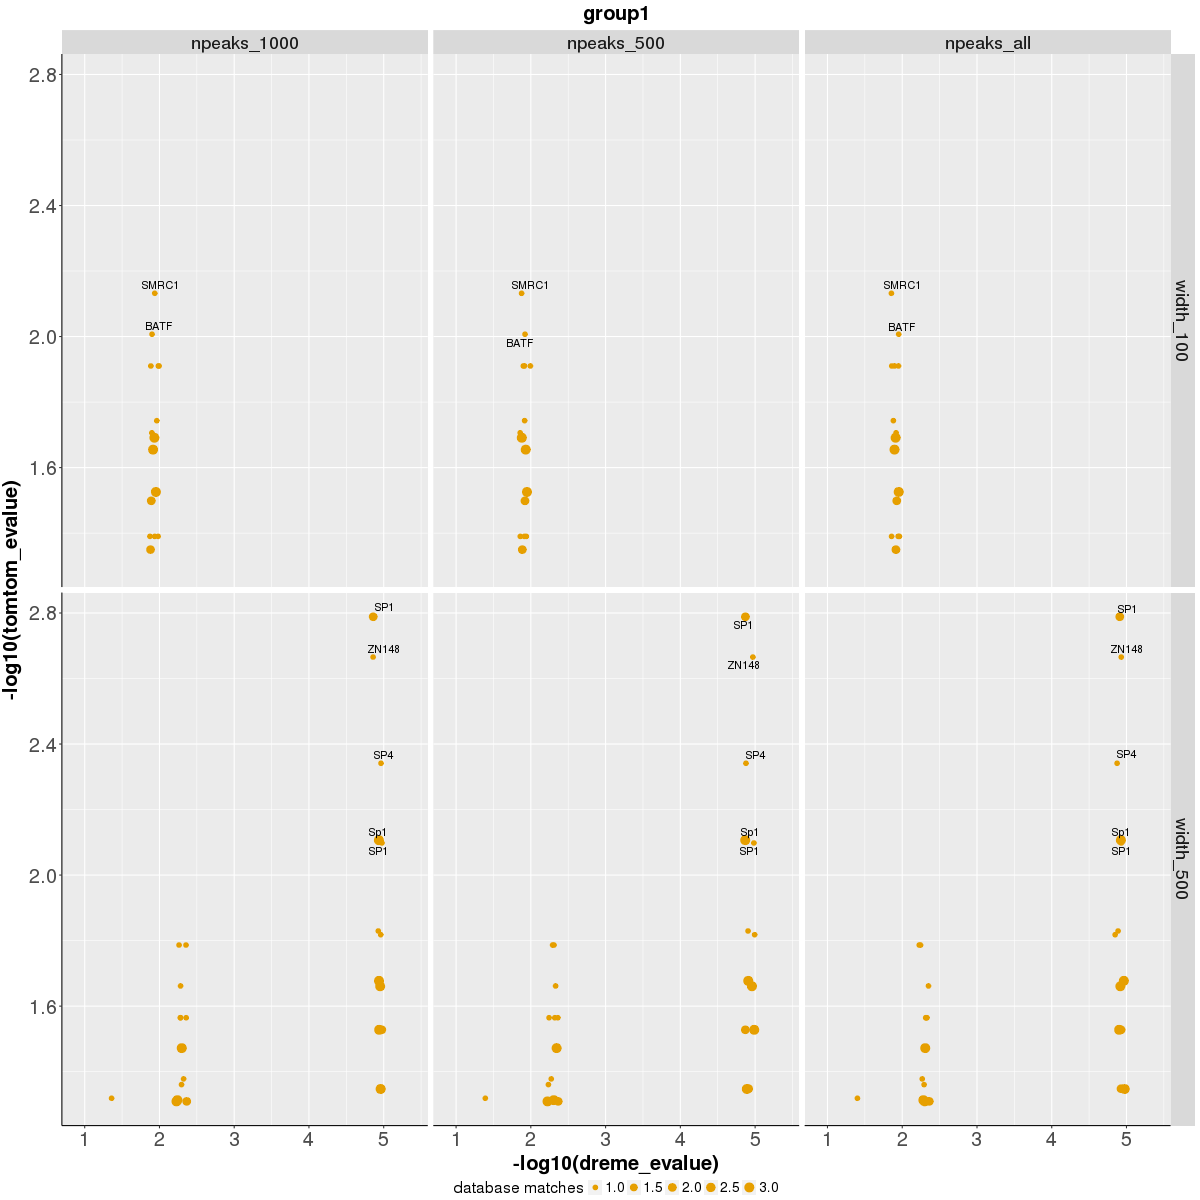

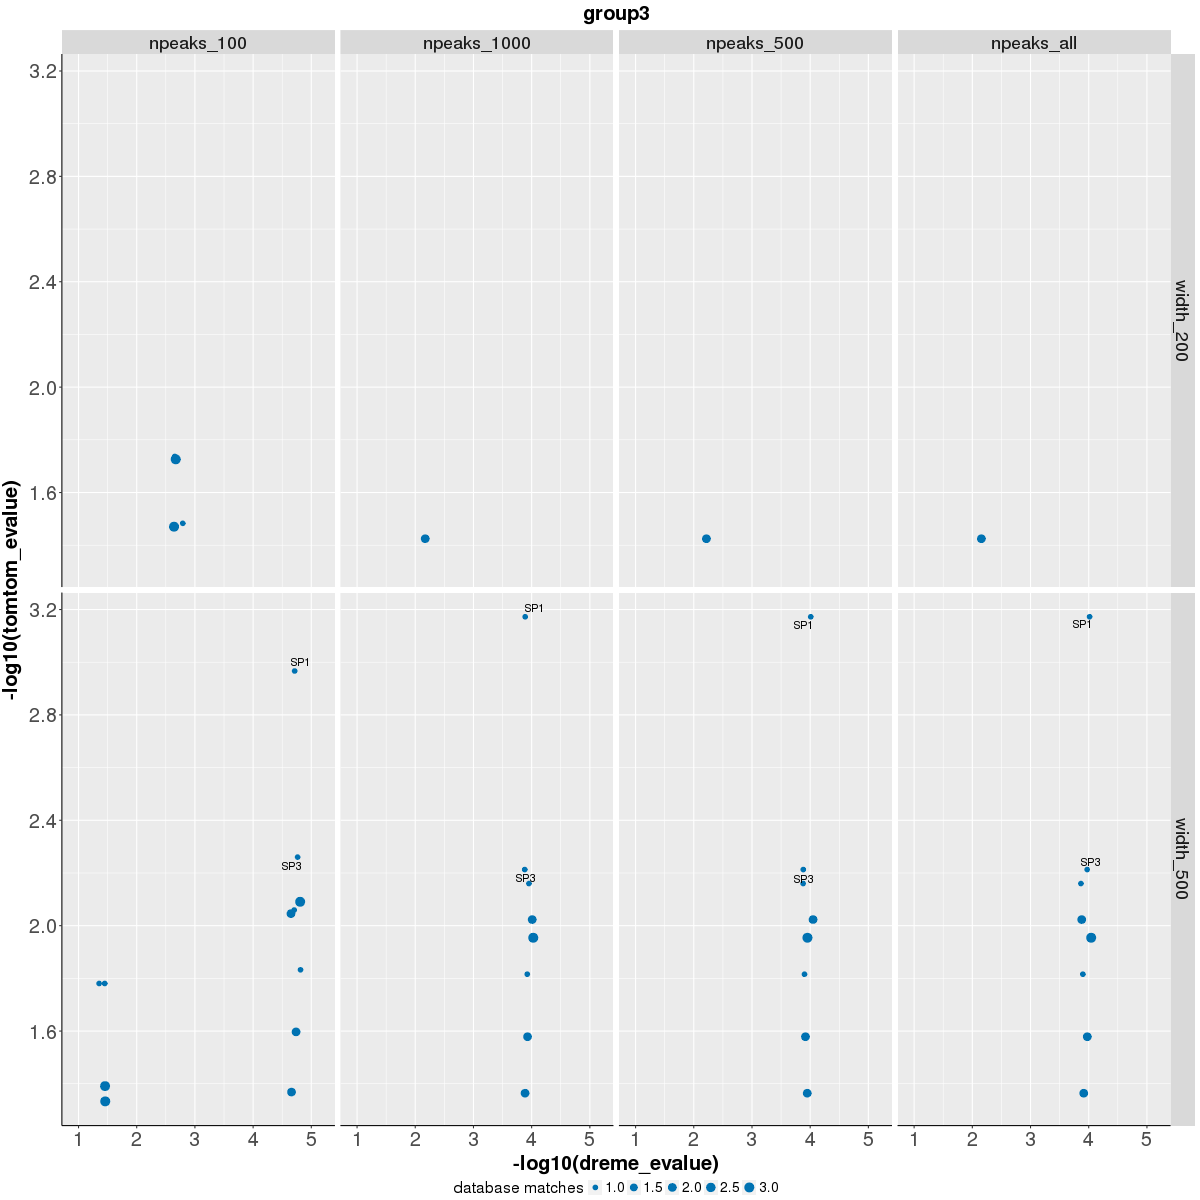

In [27]:
%%R -i dreme_graph -w 1200 -h 1200

n = 0
for (comp in unique(dreme_graph$DESeq2_comparison)){
    n = n + 1
    df <- subset(dreme_graph, DESeq2_comparison == comp)

    p <- ggplot(df, aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue))) +
        geom_point(aes(size=database), position=position_jitterdodge(), colour=Palette[[n]]) + 
        scale_size(range=c(2,4), name="database matches") +
        scale_alpha(range=c(0.4,1)) +
        geom_text_repel(data=df[-log10(df$"tomtom_evalue") > 
                                       quantile(-log10(df$"tomtom_evalue"), 0.8, na.rm=T), ], 
                        aes(y=-log10(tomtom_evalue), x=-log10(dreme_evalue), label=motif_name), colour="black", alpha=1) +
        facet_grid(width ~ peaks) +
        theme(legend.position="bottom", legend.direction="horizontal") +
        scale_colour_manual(values=Palette) +
        guides(color=guide_legend(override.aes=list(size=6))) +
        guides(alpha=guide_legend(override.aes=list(size=6)))  +
        labs(title=comp)
    
    grid.arrange(p, ncol=1, nrow=1)
}

***
<br>
### Top TF Matches for Discovered Motifs
- For each motif found by dreme the top 5 database matches are shown

In [34]:
tfs = dreme_chip.groupby(["motif", "DESeq2_comparison", "dreme_evalue", "tomtom_evalue", "settings"])["motif_name"].unique()
tfs = pd.DataFrame(tfs)
tfs.reset_index(inplace=True)
tfs["motif_name"] = tfs["motif_name"].apply(lambda x:''.join(x))
tfs["motif"] = tfs["motif"].astype(str)
tfs = tfs.groupby(["motif", "settings"]).head(5) # get top 5 db matches for each discovered motif

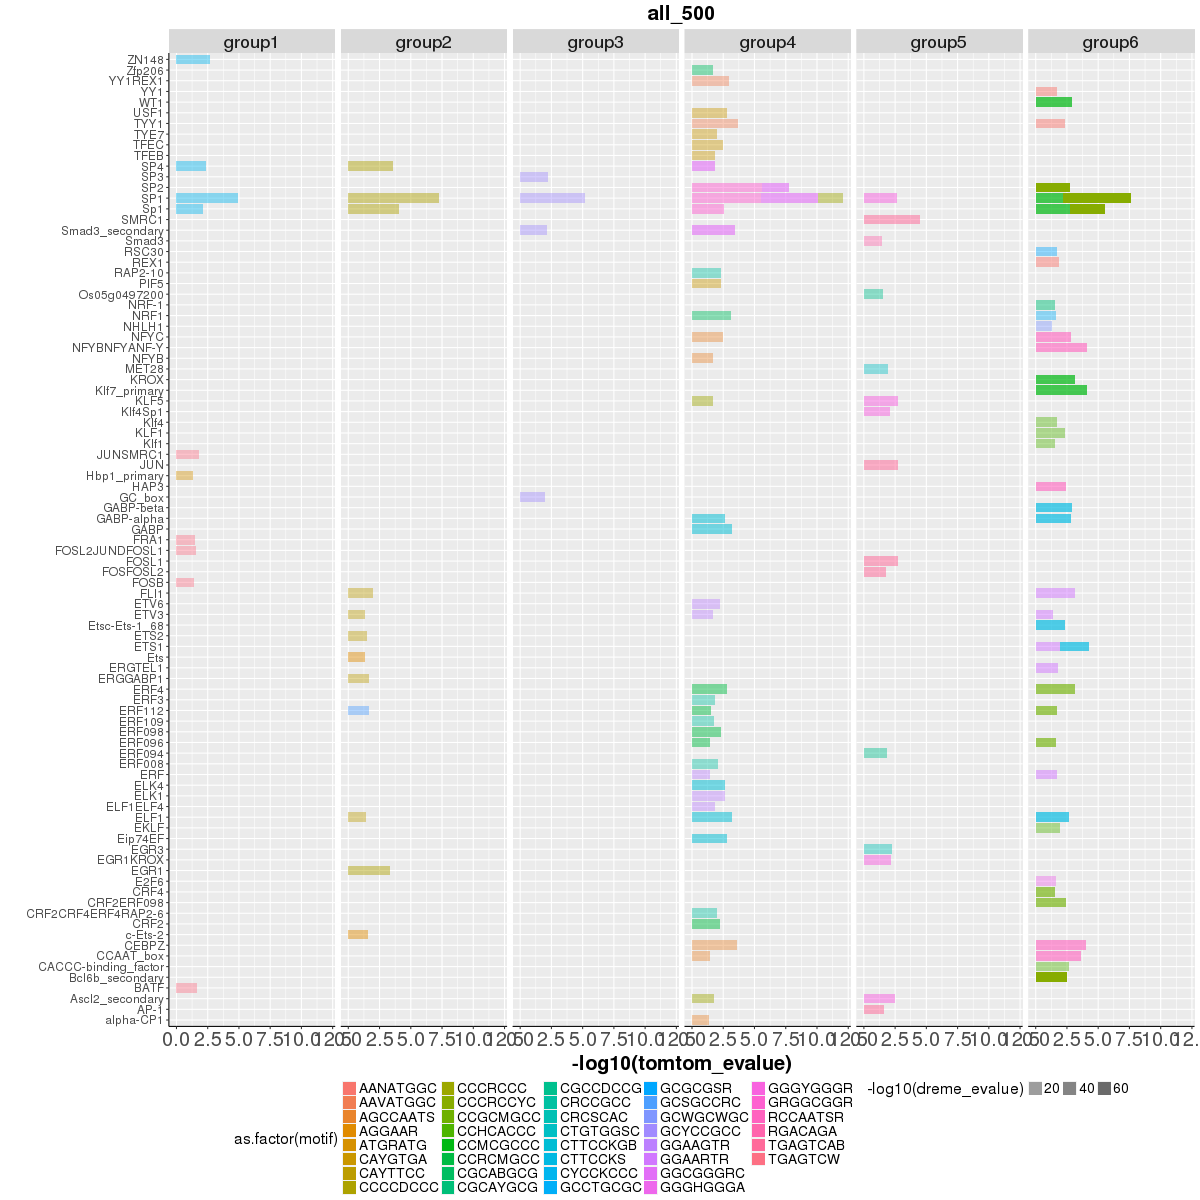

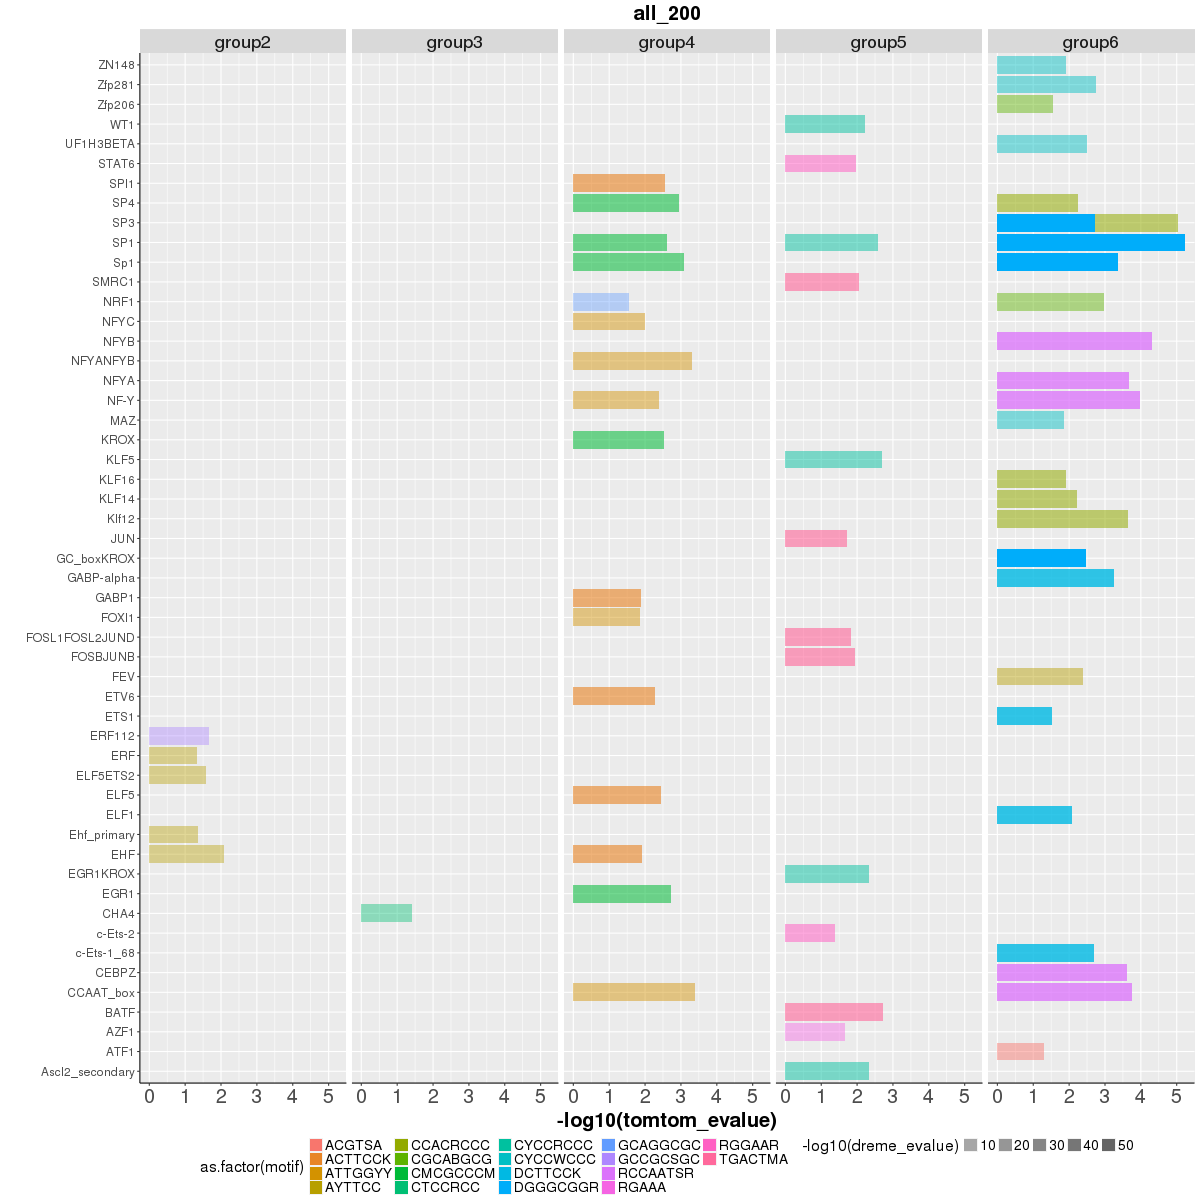

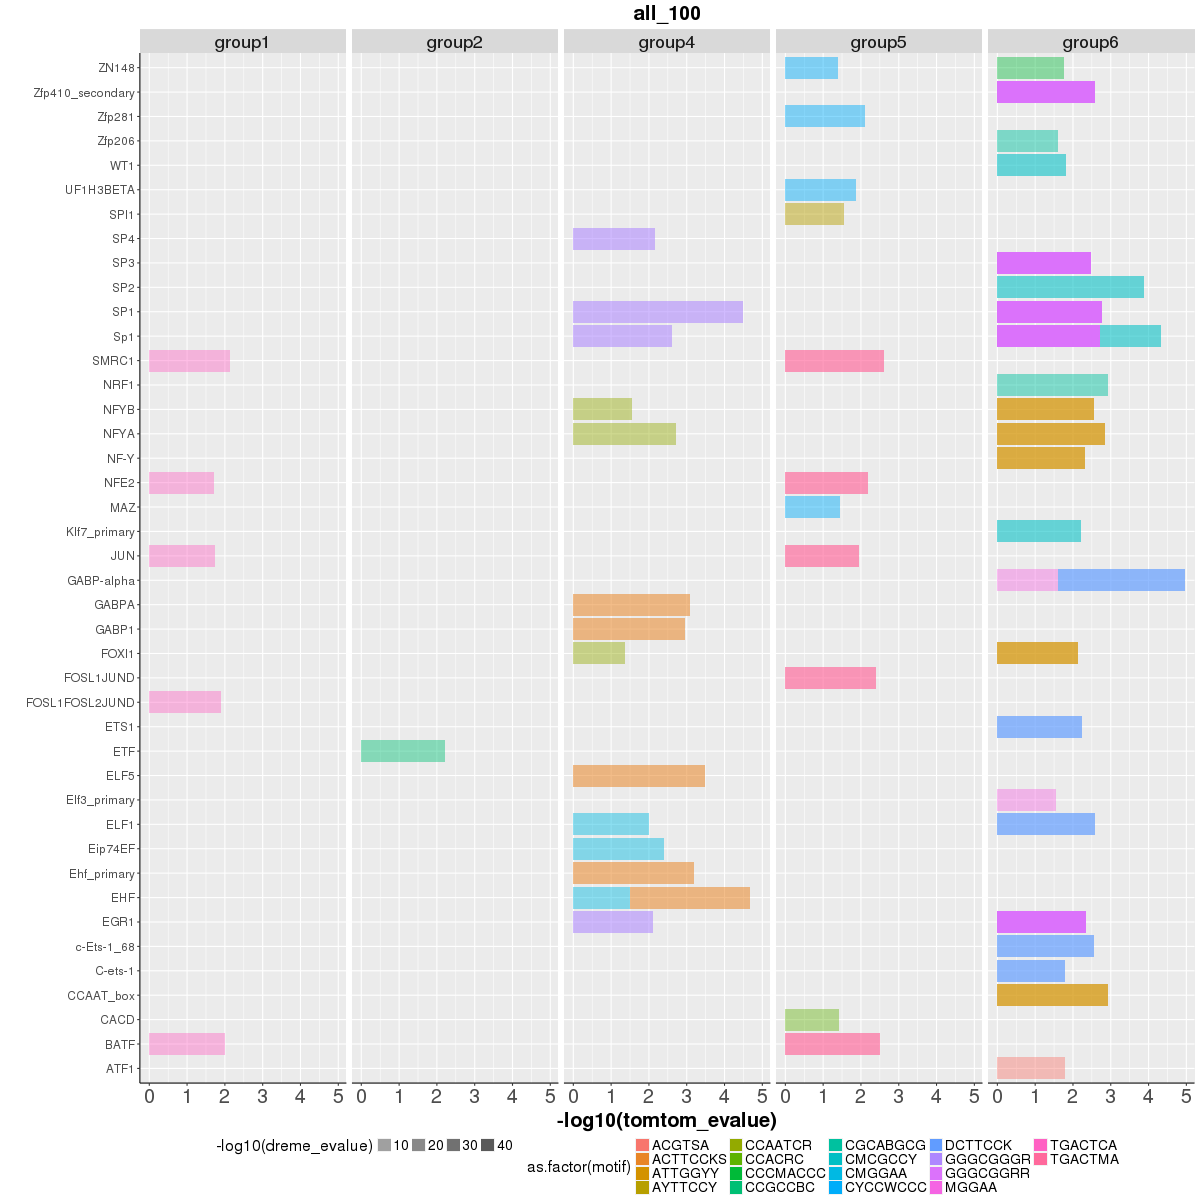

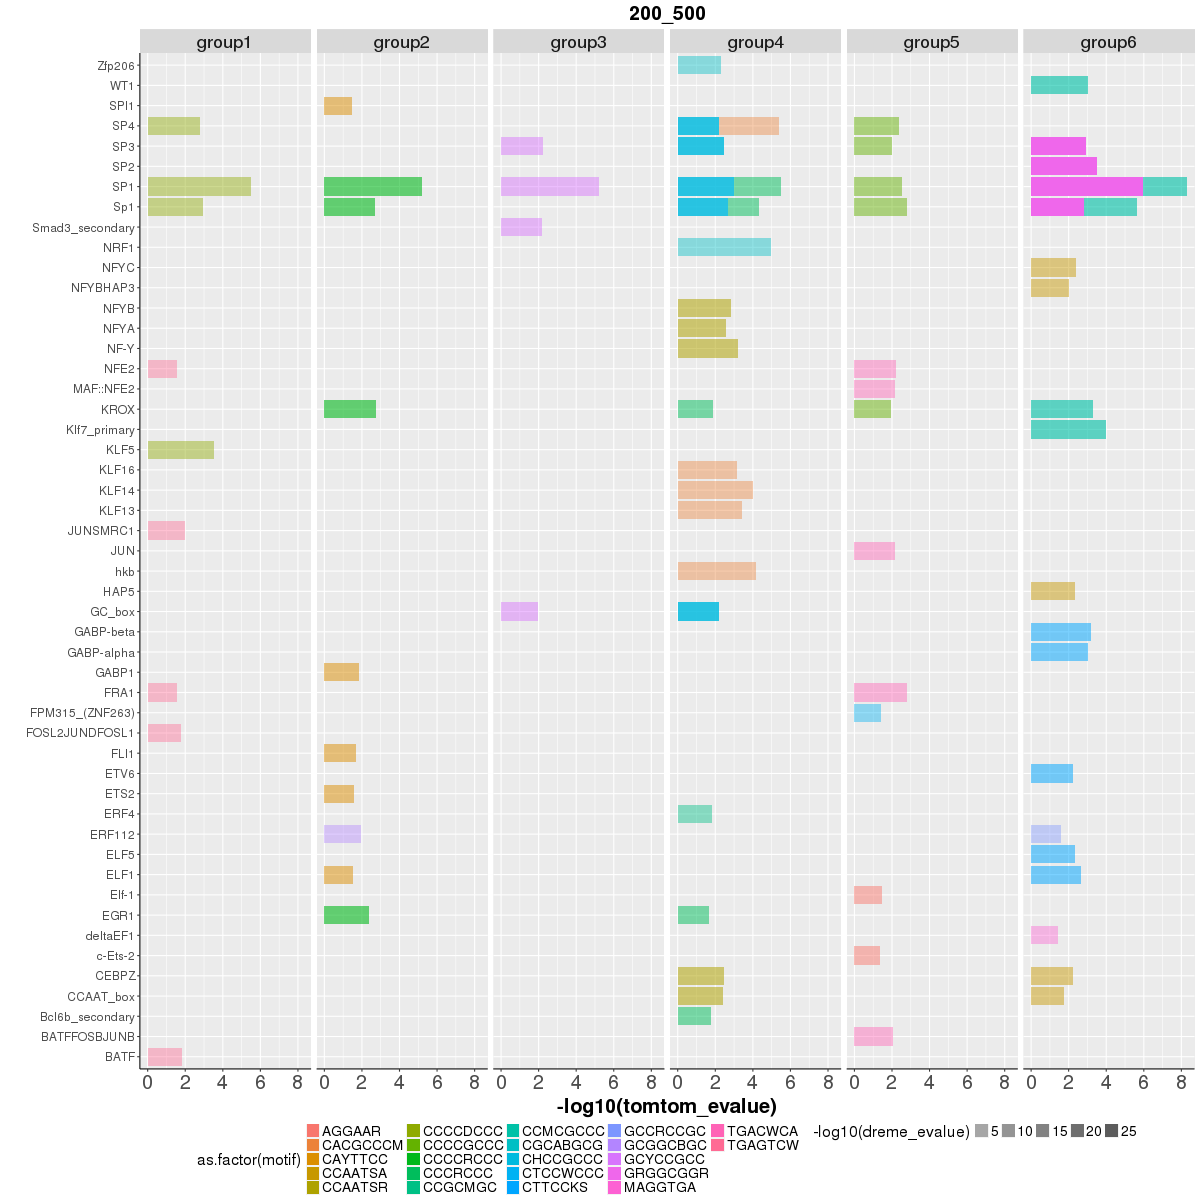

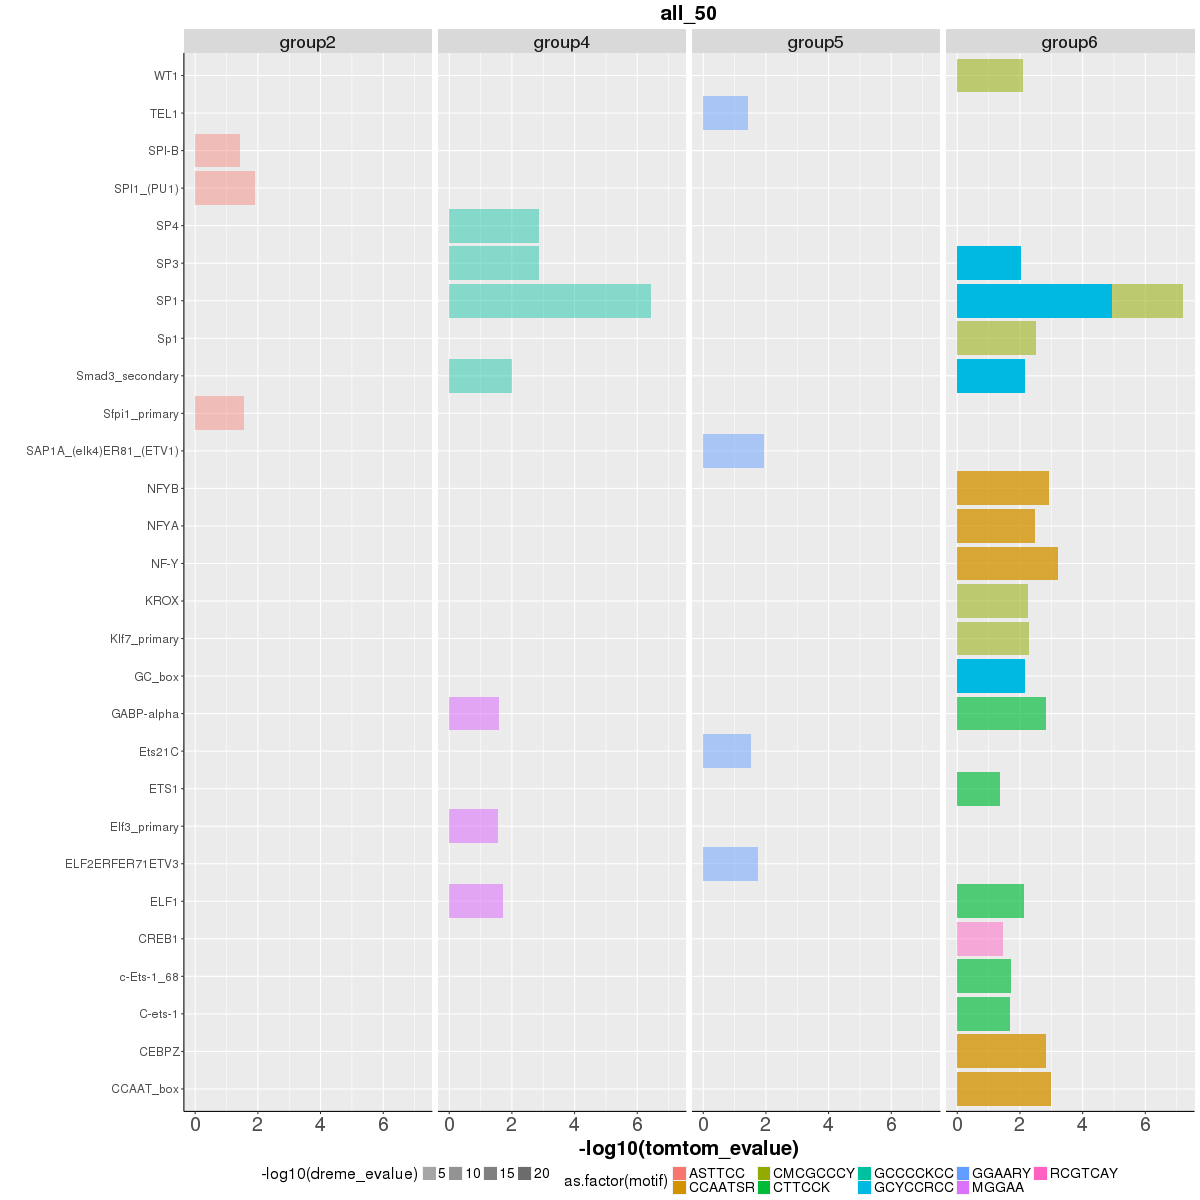

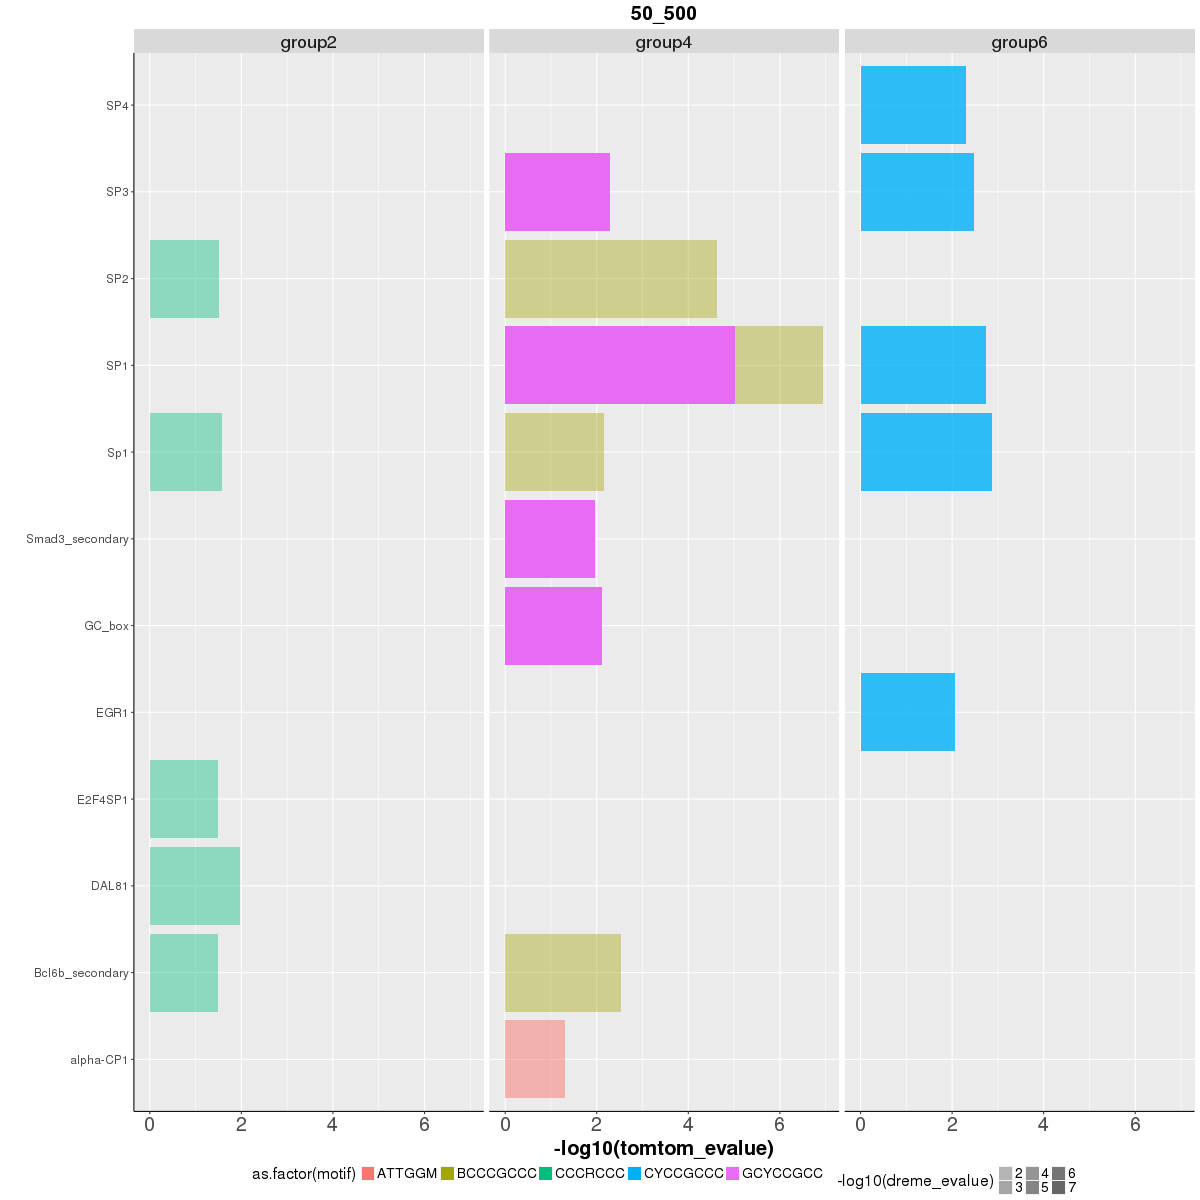

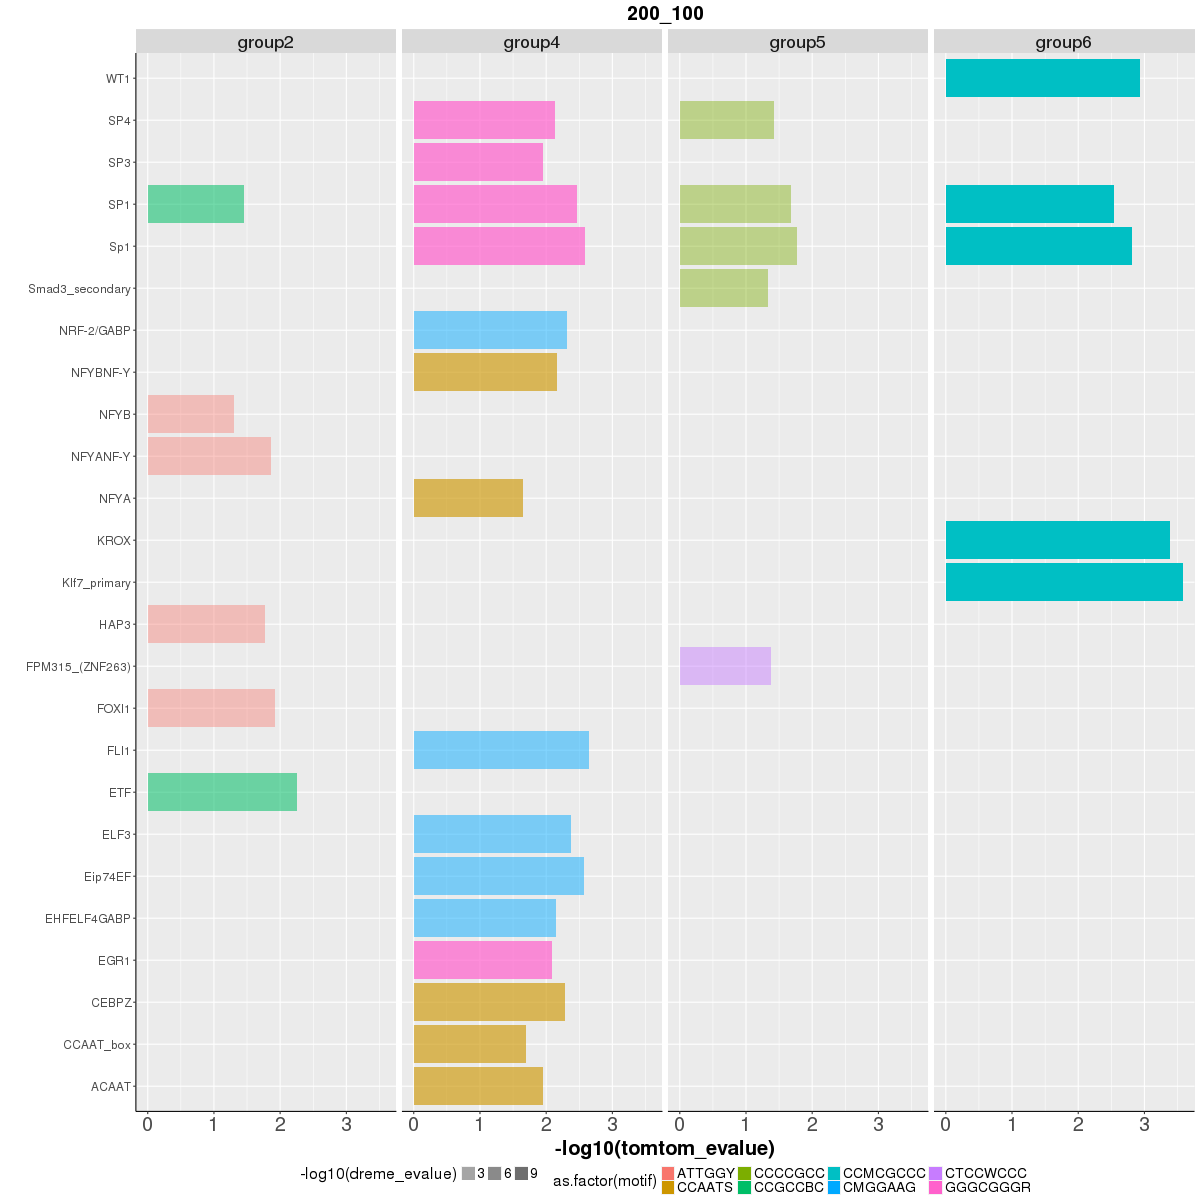

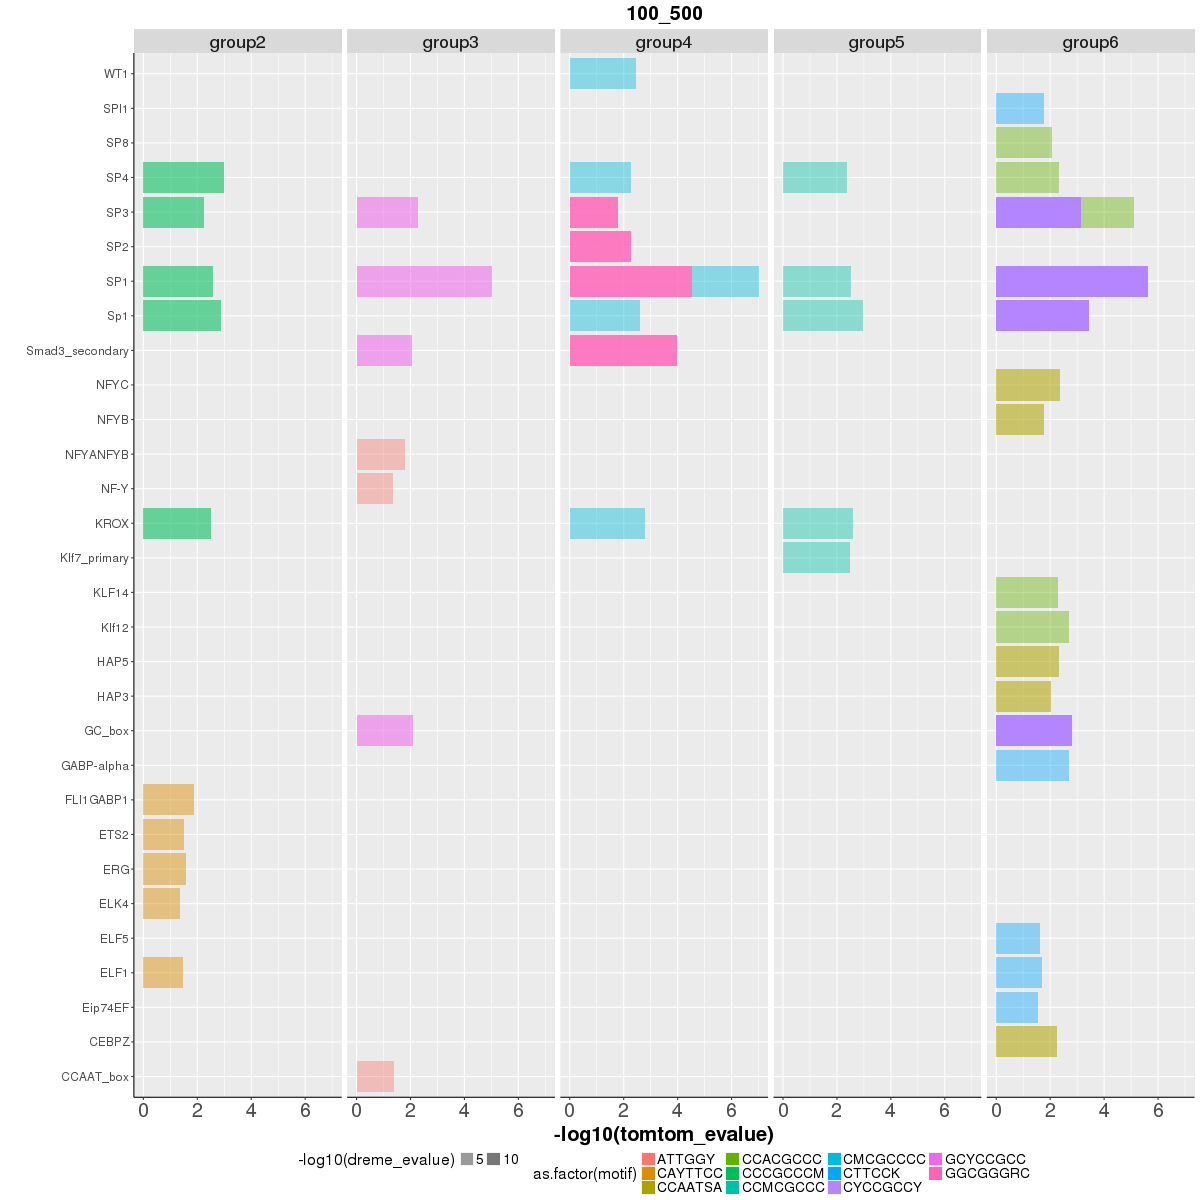

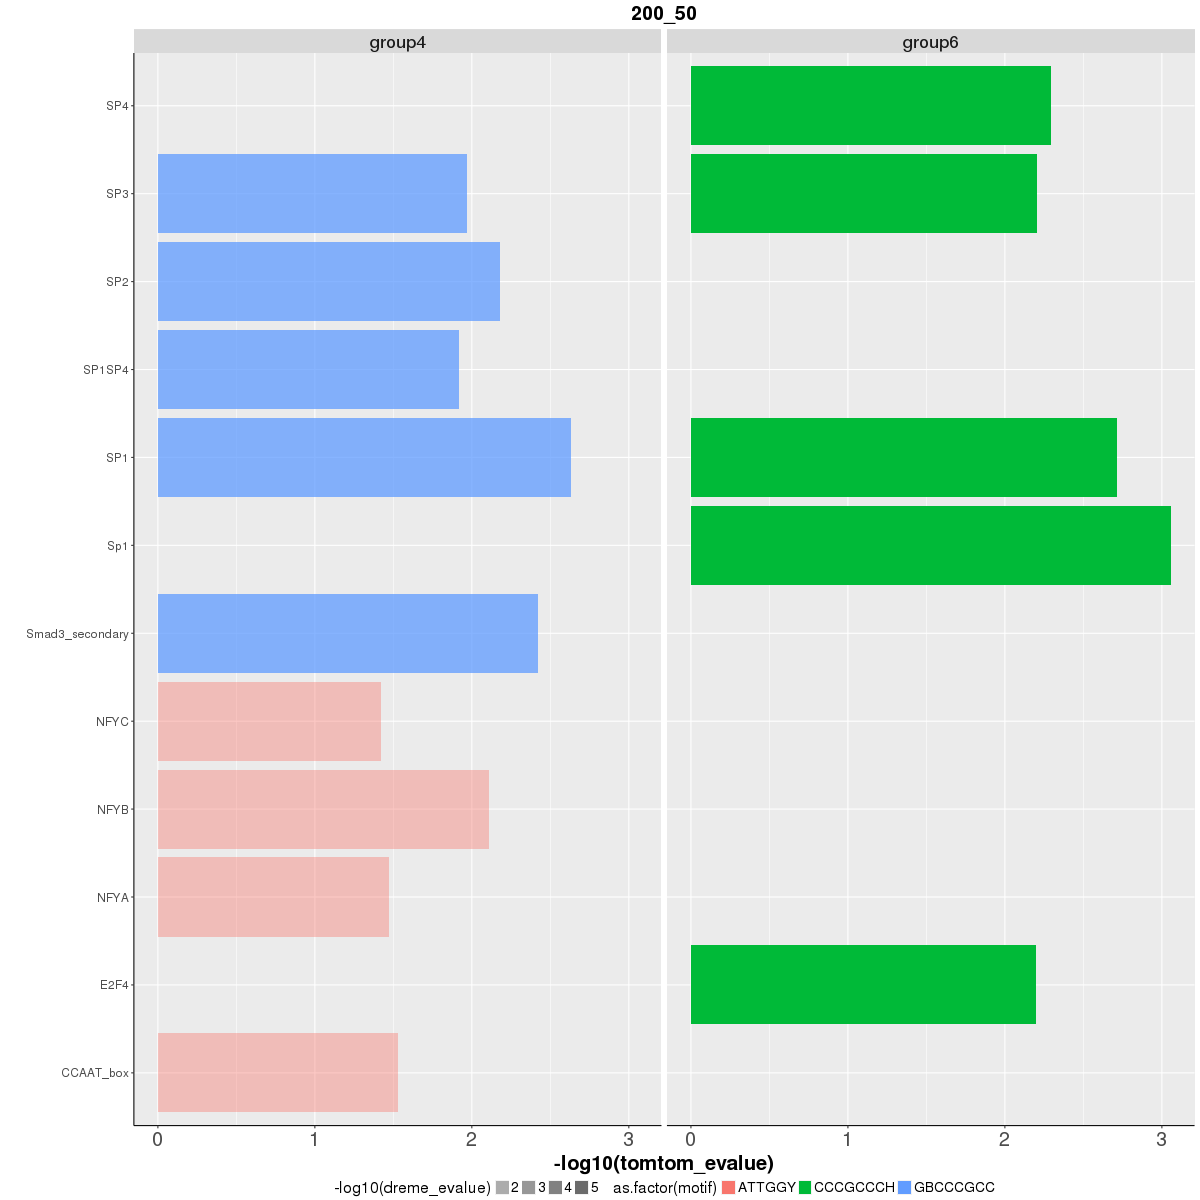

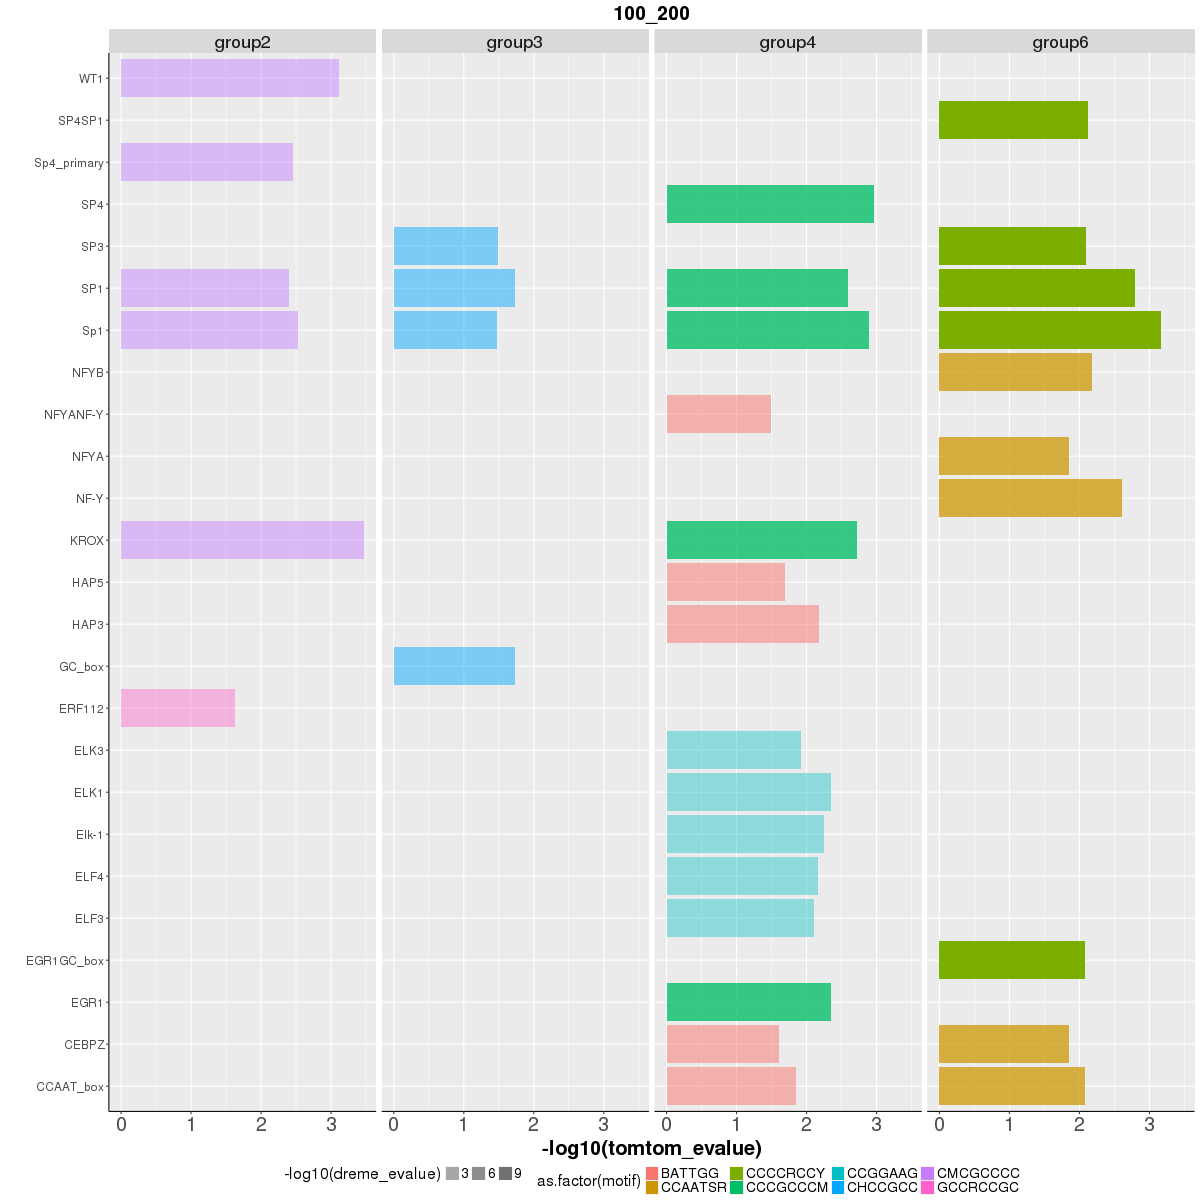

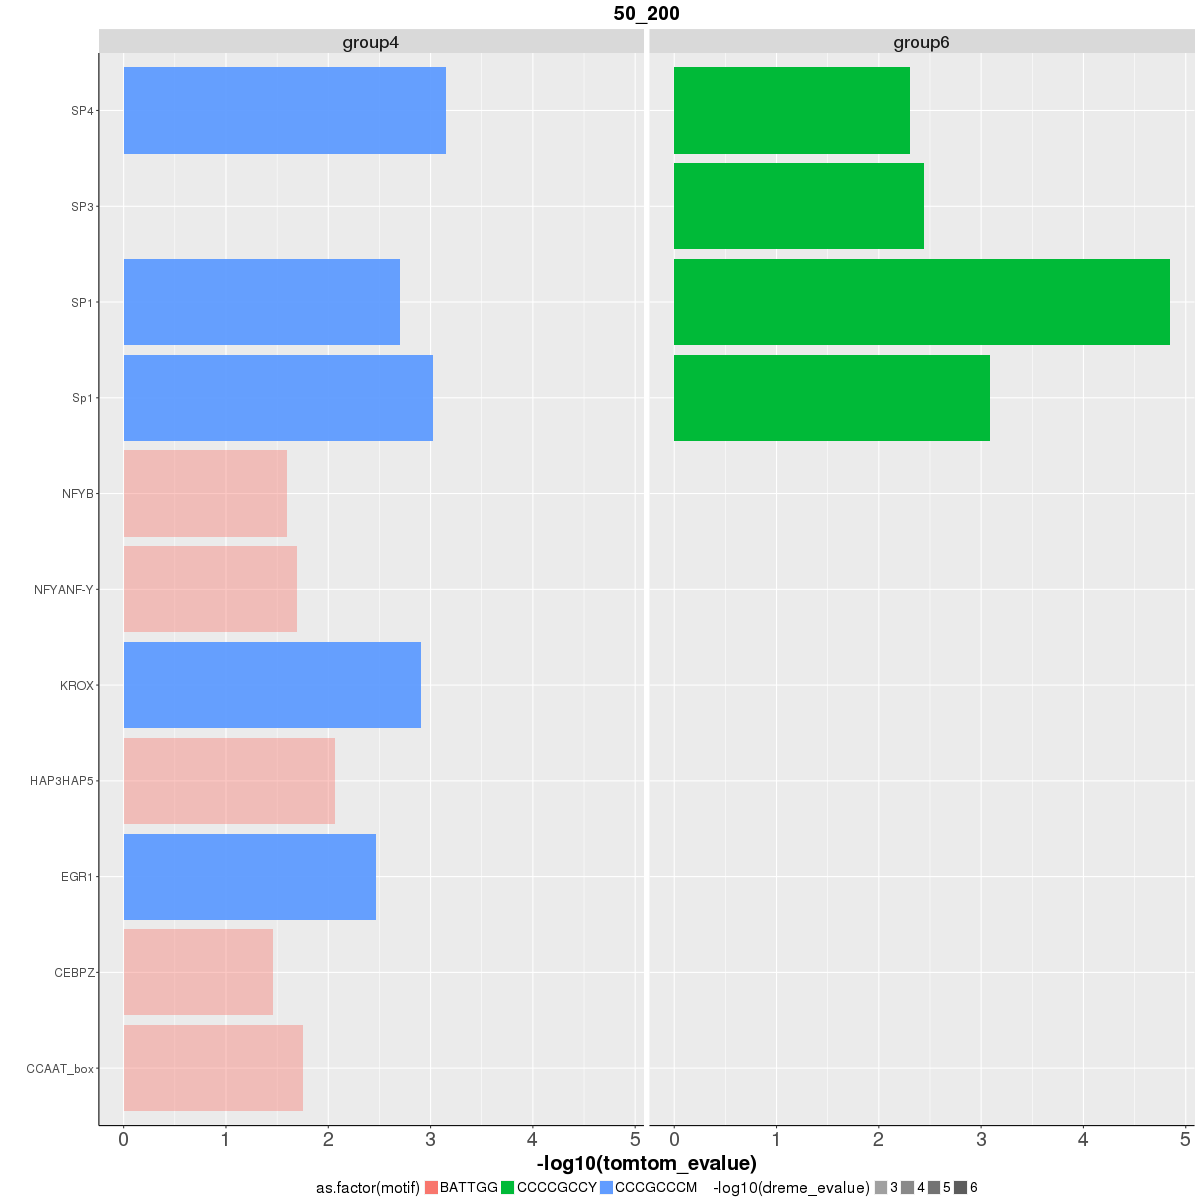

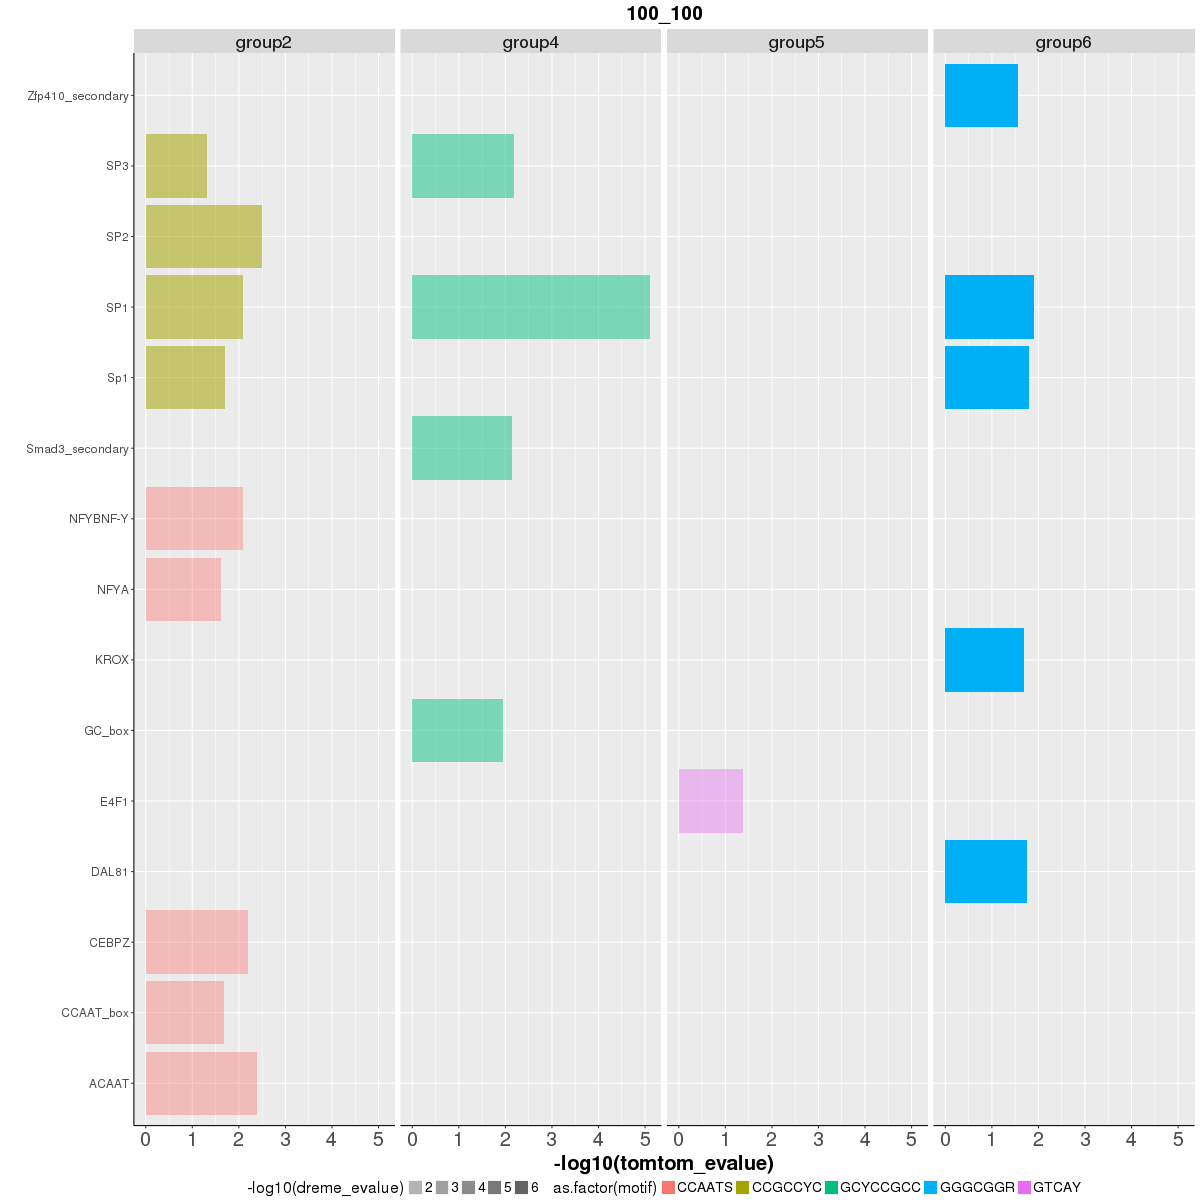

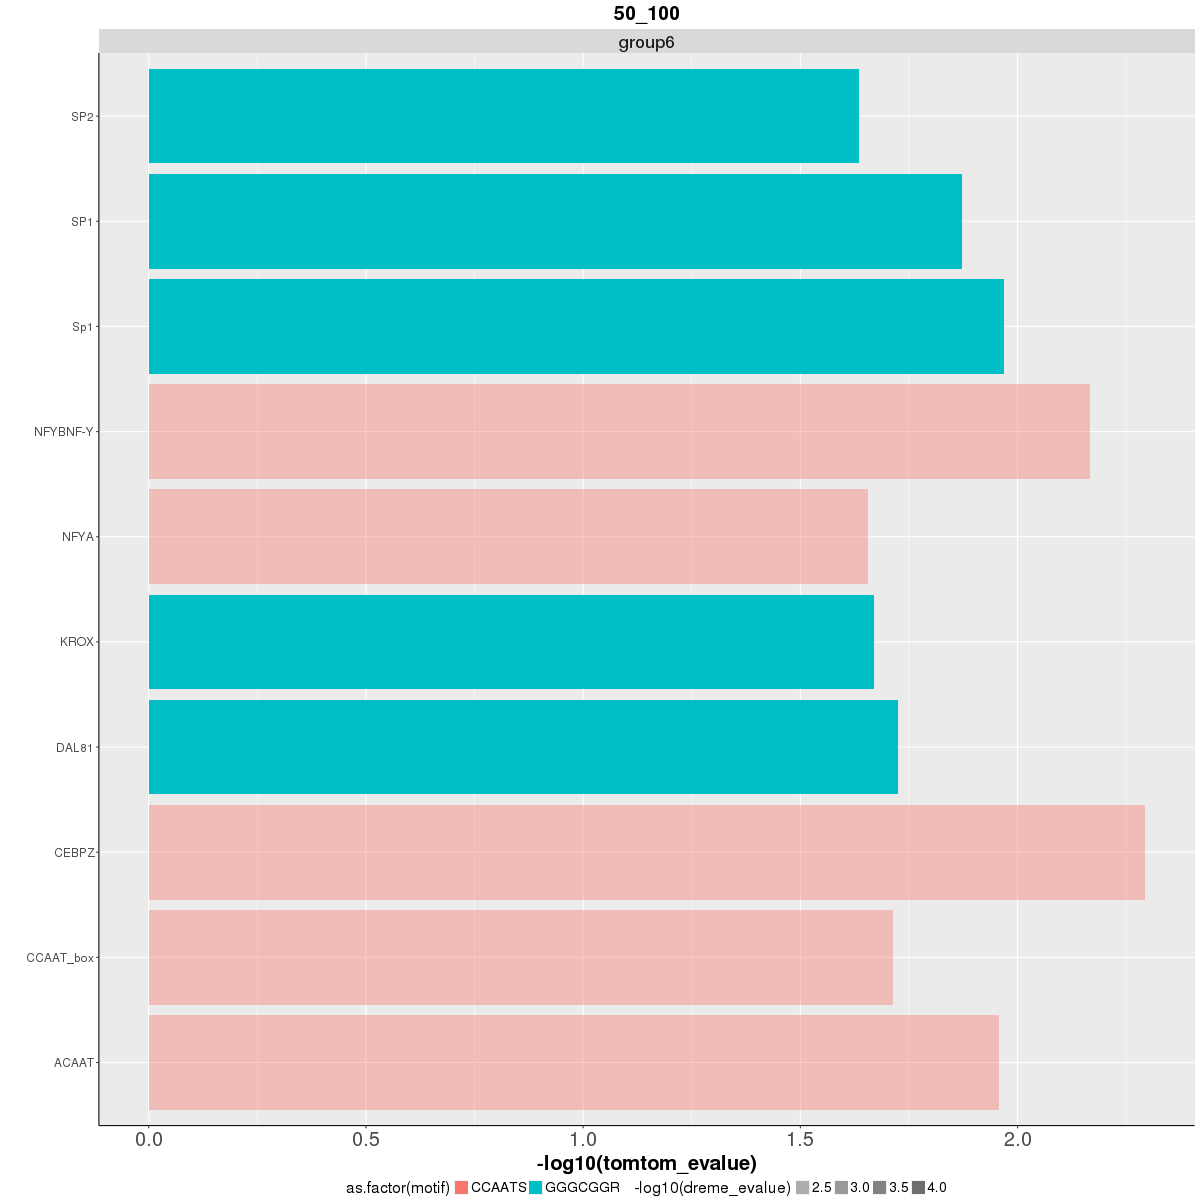

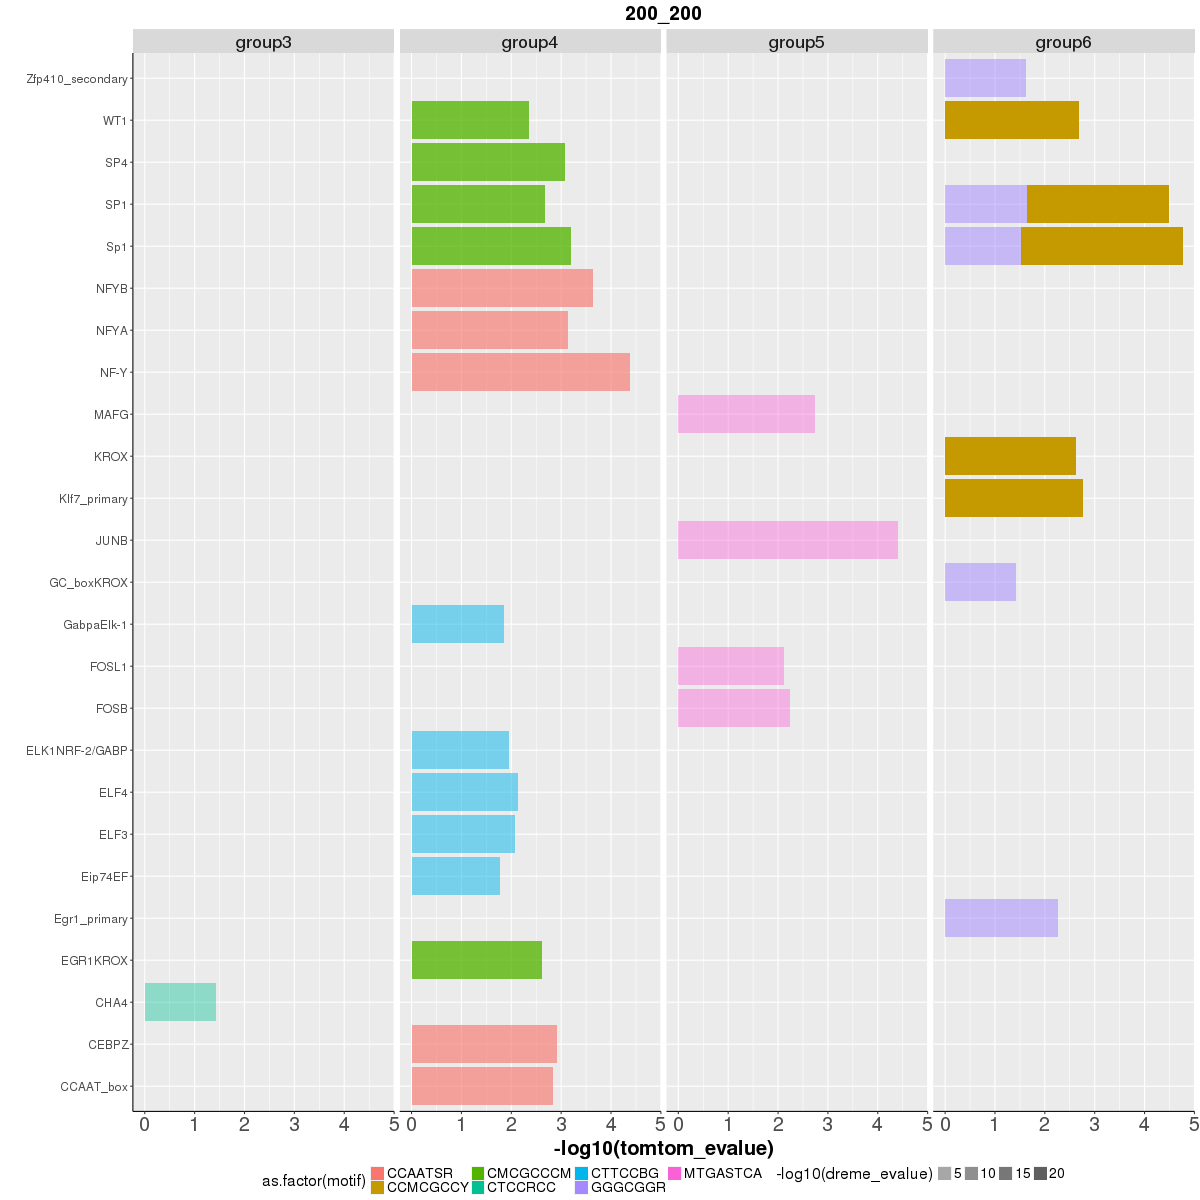

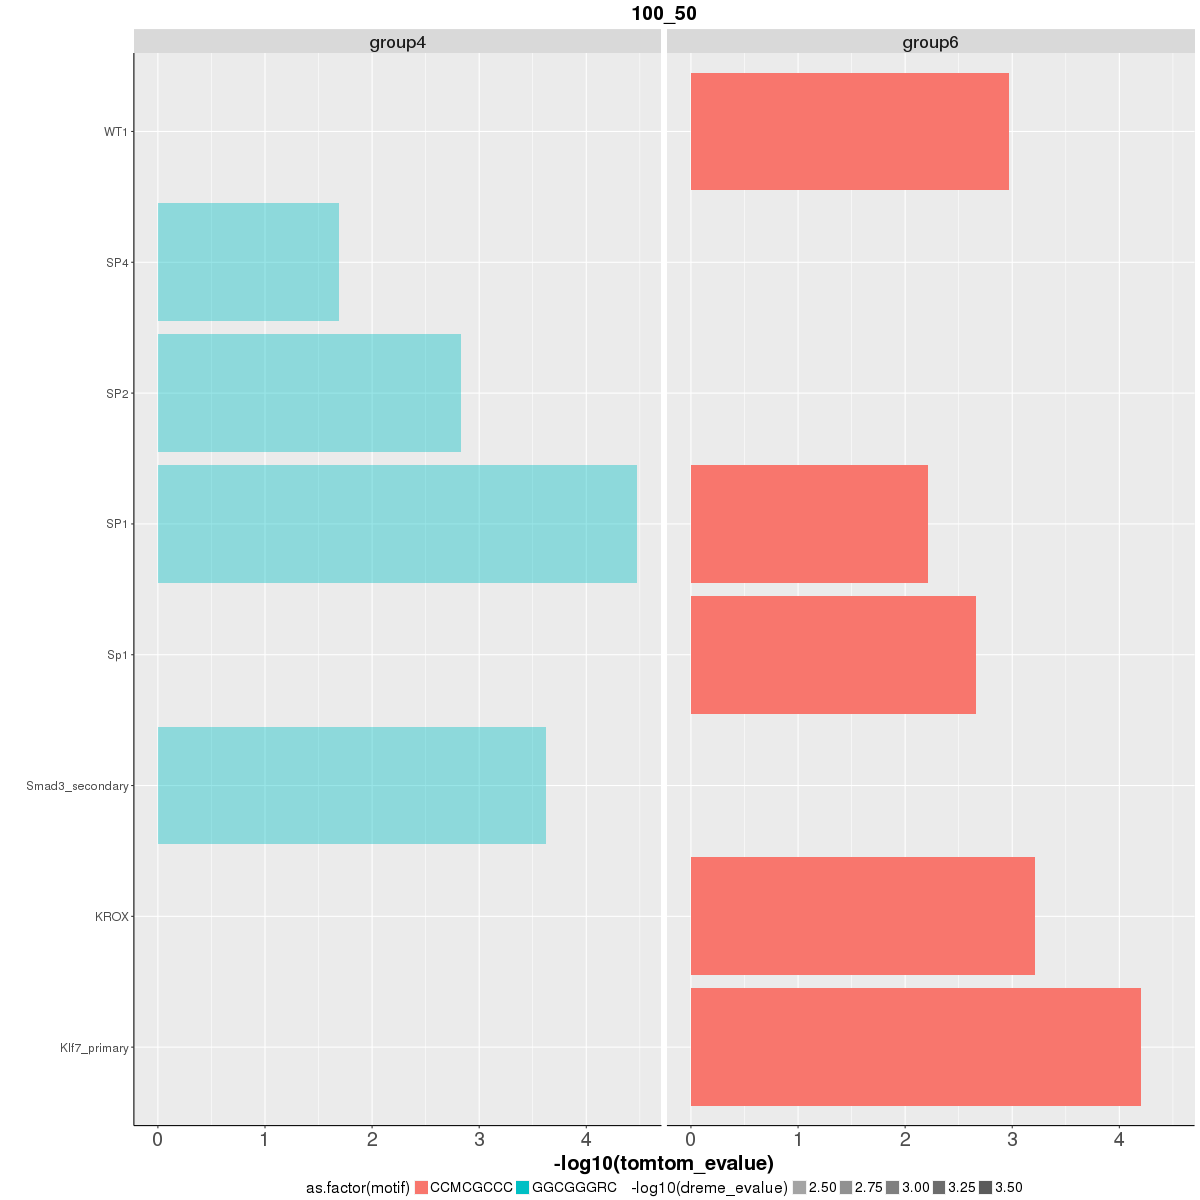

In [37]:
%%R -i tfs -w 1200 -h 1200

settings <- unique(tfs$settings)

for (setting in settings){
    p <- ggplot(subset(tfs, settings == setting), 
                aes(y=-log10(tomtom_evalue), x=motif_name, fill=motif, alpha=-log10(dreme_evalue))) + 
            geom_bar(stat="identity", position="dodge") + 
            coord_flip() +
            scale_alpha(range=c(0.4,1 )) +
            facet_wrap( ~ DESeq2_comparison, nrow=1) +
            theme(axis.text.y=element_text(size=12)) +
            theme(legend.position="bottom", legend.direction="horizontal") +
            labs(title=setting, x="")

    grid.arrange(p, ncol=1, nrow=1)
}


<br>
## Top Motif Tables:
* Sorted by TOMTOM e-value

In [30]:
if "condition" in dreme_chip.columns:
    for i in dreme_chip["DESeq2_comparison"].unique():
        print i + " - Peaks with increased accessibility"
        dreme_chip[(dreme_chip.DESeq2_comparison == i) & (dreme_chip.condition == "increase")].sort_values(["window", "tomtom_evalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(20)
        print " "
else:
     for i in dreme_chip["DESeq2_comparison"].unique():
        print i + " (No sub condition)"
        dreme_chip[dreme_chip.DESeq2_comparison == i].sort_values(["tomtom_evalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(20)
        print " "

group1 (No sub condition)


,motif,motif_rc,pos,neg,dreme_evalue,run,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,DESeq2_comparison,no_peaks,window,settings
193,CYCCKCCC,GGGMGGRG,122,53,0.000012,group1_500_500,CCCCTCCC,MA0079.3,SP1,jaspar,0.001628,+,group1,500,500,500_500
195,CYCCKCCC,GGGMGGRG,122,53,0.000012,group1_500_500,CCCCTCCC,ZN148_MOUSE.H10MO.D,ZN148,hocomoco,0.002161,-,group1,500,500,500_500
196,CYCCKCCC,GGGMGGRG,122,53,0.000012,group1_500_500,CCCCTCCC,M01273,SP4,transfac,0.004557,+,group1,500,500,500_500
667,TGACTCA,TGAGTCA,24,1,0.012000,group1_all_100,TGACTCA,SMRC1_MOUSE.H10MO.B,SMRC1,hocomoco,0.007378,-,group1,all,100,all_100
529,CYCCKCCC,GGGMGGRG,122,53,0.000012,group1_1000_500,CCCCTCCC,M00933,Sp1,transfac,0.007824,+,group1,1000,500,1000_500
532,CYCCKCCC,GGGMGGRG,122,53,0.000012,group1_1000_500,CCCCTCCC,SP1_MOUSE.H10MO.S,SP1,hocomoco,0.007979,-,group1,1000,500,1000_500
4,TGACTCA,TGAGTCA,24,1,0.012000,group1_500_100,TGACTCA,BATF_MOUSE.H10MO.B,BATF,hocomoco,0.009837,-,group1,500,100,500_100
671,TGACTCA,TGAGTCA,24,1,0.012000,group1_all_100,TGACTCA,JUND_MOUSE.H10MO.A,JUND,hocomoco,0.012297,-,group1,all,100,all_100
670,TGACTCA,TGAGTCA,24,1,0.012000,group1_all_100,TGACTCA,FOSL2_MOUSE.H10MO.A,FOSL2,hocomoco,0.012297,-,group1,all,100,all_100
669,TGACTCA,TGAGTCA,24,1,0.012000,group1_all_100,TGACTCA,FOSL1_MOUSE.H10MO.C,FOSL1,hocomoco,0.012297,+,group1,all,100,all_100


 
group3 (No sub condition)


,motif,motif_rc,pos,neg,dreme_evalue,run,query_consensus,target_id,motif_name,database,tomtom_evalue,orientation,DESeq2_comparison,no_peaks,window,settings
1334,GCYCCGCC,GGCGGRGC,69,21,0.000110,group3_1000_500,GCCCCGCC,SP1_MOUSE.H10MO.S,SP1,hocomoco,0.000672,-,group3,1000,500,1000_500
1035,GCYCCGCC,GGCGGRGC,52,12,0.000019,group3_100_500,GCCCCGCC,SP3_MOUSE.H10MO.B,SP3,hocomoco,0.005493,-,group3,100,500,100_500
1467,GCYCCGCC,GGCGGRGC,69,21,0.000110,group3_all_500,GCCCCGCC,UP00000_2,Smad3_secondary,uniprobe,0.006920,+,group3,all,500,all_500
1037,GCYCCGCC,GGCGGRGC,52,12,0.000019,group3_100_500,GCCCCGCC,M00255,GC_box,jaspar,0.008117,-,group3,100,500,100_500
1041,GCYCCGCC,GGCGGRGC,52,12,0.000019,group3_100_500,GCCCCGCC,MA0079.3,SP1,uniprobe,0.009001,+,group3,100,500,100_500
1042,GCYCCGCC,GGCGGRGC,52,12,0.000019,group3_100_500,GCCCCGCC,M01273,SP4,transfac,0.014708,+,group3,100,500,100_500
1097,ATTGGY,RCCAAT,46,15,0.042000,group3_100_500,ATTGGC,NFYA_MOUSE.H10MO.S,NFYA,hocomoco,0.016575,+,group3,100,500,100_500
1098,ATTGGY,RCCAAT,46,15,0.042000,group3_100_500,ATTGGC,NFYB_MOUSE.H10MO.A,NFYB,hocomoco,0.016575,-,group3,100,500,100_500
1044,GCYCCGCC,GGCGGRGC,52,12,0.000019,group3_100_500,GCCCCGCC,MA0516.1,SP2,uniprobe,0.025300,+,group3,100,500,100_500
1006,CHCCGCC,GGCGGDG,62,25,0.002000,group3_100_200,CCCCGCC,M00933,Sp1,uniprobe,0.033857,+,group3,100,200,100_200


***

In [29]:
if "condition" in dreme_chip.columns:
    for i in dreme_chip["DESeq2_comparison"].unique():
        print i + " - Peaks with decreased accessibility"
        dreme_chip[(dreme_chip.DESeq2_comparison == i) & (dreme_chip.condition == "decrease")].sort_values(["window", "tomtom_evalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(10)